In [1]:
# Code to plot the AWG response. 
# Pradip Gatkine (24 Feb 2021)

import numpy as np;
import matplotlib.pyplot as plt
from astropy.io import fits
import math
from scipy.optimize import curve_fit
import glob
import os
import sys
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import linalg
import pprint


import re
plt.rc('font', family='serif')
from matplotlib import rc
import pandas as pd


#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

# Import File

In [2]:
# Importing the data file here. You can also simply use the name of the file here.
# This assumes that the data file is in the same folder as the code. If not, please add the relative or full path of the file
# This import statement works in Linux. A different library/statement maybe needed for Windows
#print ("Current working dir : S%s" % os.getcwd())
File_list = sorted(glob.glob("*.dat"))
for file in range(len(File_list)):
    File_list[file] = os.getcwd() + "\\" + File_list[file]
pprint.pprint(File_list)

['C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0.dat',
 'C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0_edited.dat']


In [3]:
file_num = 0
chan_num = 13 # This is the number of channels in the AWG. For higher resolution AWGs, this number will be higher.
              # You could also simply find the number of columns in the data and determine the number of channels. 

a = np.arange(0, chan_num+1)
a_string = [str(a_i) for a_i in a] 

df = pd.read_table(File_list[file_num], sep="\s+", names=a_string)
for ind in a_string[1:]:
    df[ind] = 10*np.log10(df[ind])
df['0'] = 1000*df['0']  # df['0'] is wavelength in micron, multiplying by 1000 to convert to nm.
df = df.iloc[28:] #the transmission is weirdly high and constant in the 7th channel between 1518.225000 and 1520.033333 nm

In [4]:
df

0          1          2          3          4          5  \
28   1520.033333 -10.145370 -42.122440 -59.828685 -49.149739 -53.197446   
29   1520.097917 -11.271579 -43.632960 -60.087635 -49.392293 -53.810797   
30   1520.162500 -12.513087 -44.812821 -59.996783 -49.844160 -54.441428   
31   1520.227083 -13.868504 -45.727371 -59.970460 -50.441519 -55.000427   
32   1520.291667 -15.336987 -46.380498 -59.833025 -51.107338 -55.384602   
..           ...        ...        ...        ...        ...        ...   
644  1559.816667  -8.013770 -37.500060 -64.897441 -49.474692 -52.351693   
645  1559.881250  -8.827469 -39.368273 -61.938130 -49.195380 -52.603066   
646  1559.945833  -9.745225 -41.406588 -60.278128 -49.111147 -52.997867   
647  1560.010417 -10.768259 -43.032119 -59.854118 -49.252442 -53.529308   
648  1560.075000 -11.895787 -44.276139 -60.070792 -49.594269 -54.120571   

             6          7          8          9         10         11  \
28  -54.850754 -52.107351 -53.400534 -55.320131 -52.571101 -57.980692   
29  -54.780437 -52.041251 -53.743780 -55.492176 -51.956872 -59.316564   
30  -54.628907 -51.987109 -54.043747 -55.455106 -51.301680 -59.740465   
31  -54.410908 -51.959360 -54.333931 -55.129675 -50.632968 -59.923994   
32  -54.141932 -51.978379 -54.560111 -54.619777 -50.002106 -59.939903   
..         ...        ...        ...        ...        ...        ...   
644 -54.609351 -52.292071 -52.653039 -54.360324 -53.928756 -55.510825   
645 -54.766917 -52.193044 -52.958395 -54.826350 -53.349001 -56.716359   
646 -54.849464 -52.138185 -53.271204 -55.208465 -52.796803 -57.542710   
647 -54.828829 -52.068439 -53.591695 -55.466202 -52.222053 -58.780592   
648 -54.714329 -52.019081 -53.910967 -55.503561 -51.630716 -59.619794   

            12         13  
28  -47.080194 -19.126318  
29  -46.965411 -17.401418  
30  -46.529988 -15.787734  
31  -45.935796 -14.286245  
32  -45.112271 -12.897657  
..         ...        ...  
644 -47.110866 -23.438925  
645 -46.816968 -21.587701  
646 -46.983646 -19.815234  
647 -47.094139 -18.136651  
648 -46.763439 -16.557337  

[621 rows x 14 columns]

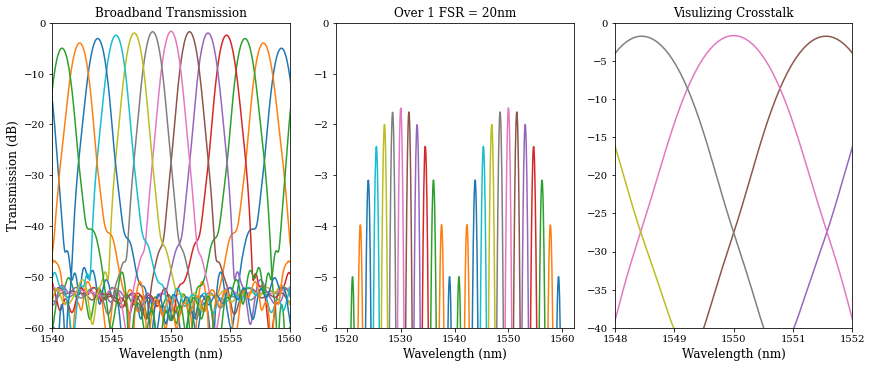

In [5]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))
#plt.plot(range(len(df['0'])), df['0'])
#done defining the Emission_line object!
fig3 = plt.figure(constrained_layout=True, figsize=(12,5))
gs = fig3.add_gridspec(1, 3) #creates grid with one row and 3 columns
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax1.set_title('Broadband Transmission')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('Over 1 FSR = 20nm')
f3_ax3 = fig3.add_subplot(gs[0, 2])
f3_ax3.set_title('Visulizing Crosstalk')
'''
So how do I display a rectangular signal? For a spectral range 
of .1 nanometers, have a constant signal! 
Let's write this very generally so it's easier to adapt for 
more complicated exercises. So for each wavelength range we have
1 dB = 10log_{10}(P/P_0). We want constant source power over a wavelength 
range of 1 angstrom. 
Since we're in the NIR instead of X ray, you don't need to worry about
individual photons as a function of wavelength.
dBm when the reference power is a single milliwatt. dBW is when the 
reference power is a single watt.
'''
#source_signal = [0]*649
stepsize = df.iloc[0,0]-df.iloc[1,0]
df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_ylabel('Transmission (dB)', fontsize=12)
f3_ax1.set_xlim(1518, 1560)
#f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
#plotting!
f3_ax2.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_xlim(1540, 1560)
#f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
#plotting!
f3_ax3.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)

File_in = File_list[file_num]
File_out = File_in[:-4]
plt.savefig(File_out + '.pdf')
plt.show()

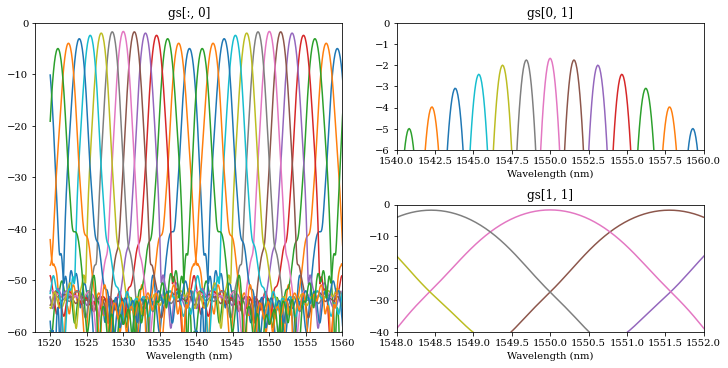

In [6]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))

fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig3.add_gridspec(2, 2)
#What does this mean/do??
f3_ax1 = fig3.add_subplot(gs[:, 0])
f3_ax1.set_title('gs[:, 0]')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('gs[0, 1]')
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax3.set_title('gs[1, 1]')


df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)')
f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
f3_ax2.set_xlabel('Wavelength (nm)')
f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
f3_ax3.set_xlabel('Wavelength (nm)')
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)
plt.show()

## ---------- Upto this part is relevant for Marcos for now ---------------------

# Plot 3-dB width

In [7]:
# Reference: 
# Peaks: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# Peak widths: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths

# Finding 3-dB width of the AWG peaks.
from scipy.signal import chirp, find_peaks, peak_widths

def find_3dB_width(lam, op_power_norm_fib, FSR):
    d_lam = lam[1]-lam[0]
    FSR_chunk = np.int(0.8*FSR/d_lam) # Taking 80% of the FSR as the minimum distance between the peaks
    #Consider the 13th channel. A distance of .8*FSR would use peaks from the next spectral order.
    op_power_norm_fib_lin = np.power(10.0,  op_power_norm_fib/10) # converting to linear scale for peak-width measurement

    peaks, _ = find_peaks(op_power_norm_fib_lin, height = .1, distance=FSR_chunk)
    #find_peaks is defind in scipy. You can use it to place the emission lines! Get the array from here
    results_half = peak_widths(op_power_norm_fib_lin, peaks, rel_height=0.5)  # rel_height = 0.5 => FWHM  (half-power beam width)
    #you can define offsets in terms of the FWHM named results_half
    return peaks, lam[peaks], op_power_norm_fib[peaks], d_lam*results_half[0], d_lam  # The zeroth element is width

In [8]:
# Marcos Perez being mentored by Pradip Gatkine and Nem Jovanovic (14 June 2021)
'''
The class calculates what rows in the dataframe are spanned by an emission line
given its shape, width, and height!

I don't assume the center, or boundaries of the emission line fall on the 
exact wavelengths listed in the first column of the dataframe.

The class Emission_line defines the relevant indices in the dataframe given 
the center-nanometers and width (or alternatively the left_boundary and right_boundary).
If its symmetrical, the input for the left_boundary and right_boundary will be 
disregarded. noramlize is a boolean and indicates whether or not the area of the
emission line should be kept at 1, regardless of height entered. 

Width is the full width of the emission line, not the half width, nor the FWHM. 

So the attributes of the class are: 
self.center_index, self.center_nanometers, self.width_nanometers, self.height, self.shape, 
self.symmetrical  self.center_index, self.smallest_nanometers, self.largest_nanometers, 
self.smallest_index, self.largest_index, self.width_indices, self.row_indices_spanned, 
self.wavelengths, self.source_power, and self.integrated_power. 
It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array.
self.wavelengths is an array of wavelengths in the dataframe spanned by the emission line 
that correspond to self.row_indices_spanned.

For Gaussian emission lines, the standard deviation is taken to be 1/6 of the full width
of the emission line. Full widths less than twice the wavelength increment (here it's approximately 1.5 nm)
should be called as rectangular emission lines.

To plot the simulated measurement of multiple emission lines, add the arrays each named
self.integrated_power.
'''
class Emission_line:
   
     #now to find the closest row to the desired center_nanometers
    def __init__(self, center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, normalize):
        #center_index is the index of the center row of the emission line based on its wavelength
        #Will be calculated later
        self.center_index = 0
        self.shape = shape 
        if (self.shape == "Gaussian" or self.shape == "gaussian"):
                stan_dev = width_nanometers/6 
                #Needs have FWHM equal to the full width of a corresponding rectangular profile
                width_nanometers = 20
                #This way, the Gaussian will span the entire spectral range
        self.center_nanometers = center_nanometers
        self.width_nanometers = width_nanometers 
        self.height = height 
        self.symmetrical = symmetrical
        if(not symmetrical and (left_boundary and right_boundary)):
            self.left_boundary = left_boundary
            self.right_boundary = right_boundary
        #Find the what row best corresponds to the wavelength of the center of the emission line

        for index in list(range(df.shape[0])):
            if (df.iloc[index,0] == center_nanometers or df.iloc[index,0] > center_nanometers):
                '''
                if there is no wavelength exactly equal to the center we choose the 
                smallest index greater than the desired center. The same will be done for the 
                left boundary (smallest_nanometers) of the emission line. For the right boundary 
                (largest_nanometers) of the emission line, we will instead choose the largest 
                wavelength in the dataframe smaller than the right boundary. 
                '''
                center_index = index
                break
        try: 
            width_indices  = 1
            smallest_index = 0
            largest_index = df.shape[0]-1
            if(symmetrical):
                self.smallest_nanometers = center_nanometers - (.5*width_nanometers)
                self.largest_nanometers = center_nanometers + (.5*width_nanometers)
            else:
                self.smallest_nanometers = left_boundary
                self.largest_nanometers = right_boundary
            left_range = list(range(0, center_index)) 
            left_range.reverse()
            #left_range is the range within which we'll search for the row with the smallest wavelength
            for index in left_range:
                if (df.iloc[index,0] == self.smallest_nanometers):
                    smallest_index = index
                    break
                elif (df.iloc[index,0] < self.smallest_nanometers):
                    smallest_index = index+1
                    break
            for index in list(range(center_index, df.shape[0])):
                 if (df.iloc[index,0] == self.largest_nanometers):
                    largest_index = index
                    break
                 elif (df.iloc[index,0] > self.largest_nanometers):
                    largest_index = index-1
                    break
            if (largest_index < smallest_index):
                smallest_index, largest_index = largest_index, smallest_index
                '''
                This can happen for < .1 nm emission lines that are exactly one of the ones in the row.
                '''
            else :
                width_indices = largest_index-smallest_index+1
            #adding 1 to include the smallest index and to make it match with self.row_indices_spanned
            self.center_index = center_index
            #smallest_index is the index of the highest row of the emission line based on its wavelength
            self.smallest_index = smallest_index
            #largest_index is the index of the highest row of the emission line based on its wavelength
            self.largest_index = largest_index
            self.width_indices = width_indices
            #now we'll use these indices to define the array
            #Source_power is an array of the source signal's power at each wavelength. 
            source_power = np.empty(self.width_indices)
            #self.row_indices_spanned is a 1 dimensional array
            self.row_indices_spanned = np.array(list(range(smallest_index, largest_index+1)))
            wavelengths = df.iloc[self.row_indices_spanned,0]
            wavelengths = wavelengths.to_numpy() 
            self.wavelengths = wavelengths 
            if (self.shape == "Rectangular" or self.shape == "rectangular"):
                source_power = np.array([self.height]*self.width_indices)
                if (normalize):
                    source_power = source_power/len(self.row_indices_spanned) 
                #This normalizes the emission line for different widths

            elif (self.shape == "Gaussian" or self.shape == "gaussian"):
                source_power = np.array([self.height]*self.width_indices)
                #here stan_dev is the standard deviation of the Gaussian for the emission line
                #here cont_distr is the continuous distribution of the Gaussian for the emission line
                cont_distr = norm(center_nanometers, stan_dev)
                source_power = cont_distr.pdf(wavelengths)
                if (normalize):
                    area_under_curve = np.trapz(source_power, wavelengths)
                #This normalizes the emission line for different widths
                #This will set the maximum of the array to be 1.   
                    if not (area_under_curve == 0):
                        source_power = source_power/area_under_curve
                        if (any(source_power > 1)):
                            print("Some transmissions will be greater than 1 for a\n" + 
                                  "normalized Gaussian emission line of this height and width")
                    else:
                        area_error_message = "Width of " + str(width_nanometers) + " is too small for a Gaussian"
                        area_error_message = area_error_message + " distribution in this dataframe."
                        area_error_message = area_error_message + " Please use rectangular shape."
                        print(area_error_message)
                else:
                    max = np.amax(source_power)
                    source_power = source_power/max
                    
            self.source_power = source_power
            #It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array
            self.power_transmitted = np.empty(len(self.source_power))
            #We will express everything in arbitary power units
        except (NameError, ValueError):
            error_message = "Wavelength of " + str(np.around(center_nanometers, 4)) + " nanometers"
            error_message =  error_message + " is longer than any wavelength listed in the dataframe"
            error_message = error_message + "\nor the emission line has at least one other invalid argument"
            print(error_message)        
            
    def calculate_power_vs_channels(self, channels):   
        '''
        Now let's plot just power vs channel. So we have the transmission in dB, 
        let's convert that to a power in arbitrary power units then sum across 
        each wavelength spanned by each spectral channel in the arrayed waveguide grating (AWG)
        '''
        '''
        In this function, wavelength is an index, not the wavelength in nanometers.
        Each element in the source_power array corresponds to a different wavelength, 
        hence the name wavelength
        '''
        rows_spanned = self.row_indices_spanned
        try:
            integrated_power = np.empty(len(channels))
            for channel in (channels):
                transmission = df.iloc[rows_spanned, channel]
                transmission = transmission.to_numpy() #necesssary because it can return a pandas.Series instead
                for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0,(transmission[wavelength]/10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = self.power_transmitted[wavelength]*self.source_power[wavelength]
                integrated_power[channel-1] = self.power_transmitted.sum()
                
        except TypeError: #this should only run if the transmission from a single channel is being simulated
            print("Only channel " + channel + " is included in the integrated power")
            transmission = df.iloc[rows_spanned, channels]
            transmission = transmission.to_numpy() #necesssary because it can return a pandas.Series instead
            for wavelength in range(len(self.source_power)): 
                    self.power_transmitted[wavelength] = np.power(10.0,(transmission[wavelength]/10))
                    #based on our definition of transmission
                    self.power_transmitted[wavelength] = self.power_transmitted[wavelength]*self.source_power[wavelength]
            integrated_power = self.power_transmitted.sum()
        #Here we normalize each emission line by making the peak 1 (linear scale) rather than making the area 1
        max = np.amax(integrated_power)
        #if (max > 1): 
        #    integrated_power = integrated_power/max
        self.integrated_power = integrated_power
        
test = Emission_line(1540, 0.1, 1, "Rectangular", True, 0, 0, False)

In [9]:
'''
We need to find the peak wavelength of a channel to use as the center wavelength for 
the first emission line! We will use the find_peaks() function built into scipy and used by Pradip
in the find_3dB_width() function.
Then we will find the appropriate rows by initializing an Emission_line object. Then call the 
function I wrote in it named calculate_power_transmitted. We will call this function
with an array including each of the desired channels, then use the attribute named self.integrated_power
to plot each output!

All of the terms have the same definition as the in the Emission_line class. 
channels is just an array of the number of channels (1 indexed).
Remember, the 0th column is still the wavelengths, not the transmission in a channel.
plot_dict is a dictionary where the keys are are the plot colors and the values are
the plot handles. Now each emission line will both be plotted as a Gaussian and a rectangular emission line.

On the first pass through plot_dict, we plot the rectnagular profile before and after transmission through the 
spectrograph. 
On the second pass, we plot the Gaussian profile before and after transmission through the spectrograph.
The 0th and 1st keys and values are used to label and plot the edges of the original rectangular emission line.

The 3dB width, or full width at half maximum (FWHM) for the Gaussian emission line will be the same as the 
full width for the rectangular emission line. Additionally, they will both have a peak of 1 on a linear scale
(so 0 on a log scale). 

We assume there must be an even number of labels in the dictionary named plot_dict. 1 for each edge of the
rectangular emission line, and 1 each for the original and transmitted rectangular and Gaussian emissions. 

The arguments xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size, and point_label_size
meant to customize the size of the label of the x axis, y axis, subtitle for each plot, the numerical label 
for the tick mark on each of the x and y axes, and the size of the red dots representing each point on the 
scatter plot
'''
 

def plot_power_vs_channels(center_nanometers, width_nanometers, height, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1, 
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, normalize):
    colors = list(plot_dict.values())
    handles = list(plot_dict.keys())
    rectangular_width = width_nanometers 
    gaussian_width = 6*width_nanometers/2.355 #we want the FWHM to be the same as the full width for the Gaussian
    #assuming the standard deviation for the Gaussian is 1/6 of the width input for the emission line class
    shortest_wavelength_channel = channels[len(channels)-1]
    #this is the channel we'll use to find out where to plot the red vertical line 
    #it will also help plot the original Gaussian and rectangular profiles
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    shortest_wavelength_peak = peaks[1][0]
    for label in list(range(int(len(plot_dict)/3))):
        if label % 2 == 0:
            shape = "Gaussian"
            width_nanometers = gaussian_width
        else:
            shape = "Rectangular"
            width_nanometers = rectangular_width
        emission_line = Emission_line(center_nanometers, width_nanometers, height, shape, symmetrical, 
                        left_boundary, right_boundary, normalize)
        emission_line.calculate_power_vs_channels(channels)
        source_power = emission_line.source_power
        wavelengths = emission_line.wavelengths
        '''
        channel_x_values is an array of the wavelengths expressed in terms of channel number for
        the original Gaussian and rectangular profiles, not for the simulated transmission!
        '''
        channel_x_values = shortest_wavelength_channel-((wavelengths-shortest_wavelength_peak)/1.5)
        #channel_x_values = channel_x_values % 13 #for emission lines outside of the spectral range
        #left_plot and right_plot indicate where each part of the Gaussian should be plotted to loop around the graph
        #right_plot = np.argwhere(channel_x_values < 13.5)
        right_plot = []
        left_plot = list(range(len(source_power)))
        for index in range(len(channel_x_values)):
            if(channel_x_values[index] < .5 or channel_x_values[index] == .5): 
                #for emission lines closer to channel 13 than channel 1
                channel_x_values[index] = channel_x_values[index] + 13
                right_plot.append(index)
                left_plot[index] = -1
            if(channel_x_values[index] > 13.5): 
                #for emission lines closer to channel 1 than channel 13
                channel_x_values[index] = channel_x_values[index] % 13 
                right_plot.append(index)
                left_plot[index] = -1
        left_plot = np.array(left_plot)
        left_plot = np.argwhere(left_plot > -1)
        right_plot = np.array(right_plot)
        right_plot = right_plot.astype('int32')
        integrated_power = emission_line.integrated_power
        if(is_dB):    
            integrated_power = 10 * np.log10(integrated_power)
            source_power = 10 * np.log10(source_power)
        if (shape == "Rectangular"):
            ax1.axvline(x = channel_x_values[0], ymin = 0, ymax = 0.923076923, linestyle='solid', 
                        color = colors[0], linewidth = .65)
            ax1.axvline(x = channel_x_values[len(channel_x_values)-1], ymin = 0, ymax = 0.923076923, 
                        linestyle='solid', color = colors[0], linewidth = .65, label = handles[0])
        if (label == 0):
            line_x = shortest_wavelength_channel-((center_nanometers-shortest_wavelength_peak)/1.5)
            line_x = line_x % 13 #for emission lines outside of the spectral range
            if(line_x < .5): #for emission lines closer to channel 13 than channel 1
                line_x = line_x + 13
            ax1.axvline(x = line_x, ymin = 0, ymax = 0.923076923, linestyle='solid', 
                        color = colors[label+1], linewidth = .7, label = handles[label+1])
        #ax1.scatter(channel_x_values, source_power, s = point_label_size, color = colors[2*label+2], 
        #            label = handles[2*label+3], alpha = .5) 
        size = .1
        linewidth = .5
        ax1.plot(channel_x_values[right_plot], source_power[right_plot], marker=".", linewidth = linewidth,
                 markersize=size, color = colors[2*label+3], label = handles[2*label+3])
        ax1.plot(channel_x_values[left_plot], source_power[left_plot], marker=".", linewidth = linewidth,
                 markersize=size, color = colors[2*label+3])
        ax1.scatter(channels, integrated_power, s = point_label_size, color = colors[2*label+2], 
                   label = handles[2*label+2]) 
        #label = str(handles[label]), color = str(colors[label])
        #now to plot the original gaussian and square profiles

    '''
    The following code exports the plot to the current working directory
    path_title = "\\Simulated_Power_Transmitted_in_Each_Spectral_Channel\\"
    path_sub_title = "Single_Emission_Line"
    png_path = os.getcwd() + path_title + path_sub_title + ".png"
    pdf_path = os.getcwd() + path_title + path_sub_title + ".pdf"
    plt.savefig(png_path)
    plt.savefig(pdf_path)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(0,-60)
    '''
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    if(is_dB):    
        ylabel = 'Power in dB'
        ax1.set_ylim(-60, 5)
        plt.setp(ax1, yticks = np.array((range(-60 , 10, 10))))
    else:
        ylabel = 'Power (arbitrary units)'
        ax1.set_ylim(0 , 1)
        plt.setp(ax1, yticks = np.array((np.linspace(0 , 1, 11))))
    ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize)
    ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize)
    title = "Lines centered at " + str(np.around(center_nanometers, 4)) + " nm"
    ax1.set_title(title, fontsize = title_fontsize)
    plt.setp(ax1, xticks = np.array((range(1,14))))
    ax1.tick_params(axis='x', which='major', labelsize= xtick_size)
    ax1.tick_params(axis='y', which='major', labelsize= ytick_size)
    #legend(loc='upper center', bbox_to_anchor=(.5, -.15))

#There are 13 channels but range will only go up to 1 before the second argument!
#plot_power_vs_channels(center_nanometers, width_nanometers, height, shape, symmetrical, 
#left_boundary, right_boundary, channels, plot_dict, True)
#keep a set of plotting templates, formats and commands in place to copy and paste when needed
#We're in the initial steps of plotting, so keep the plotting commands floating rather than in a function
#Worry about additional plots once everything is set up

Text(-45, -130, 'Each rectangular profile has a height of 1 and a full width equal to the average 3dB width of each channel. Each \nGaussian profile has a FWHM equal to the average 3dB width of each channel.')

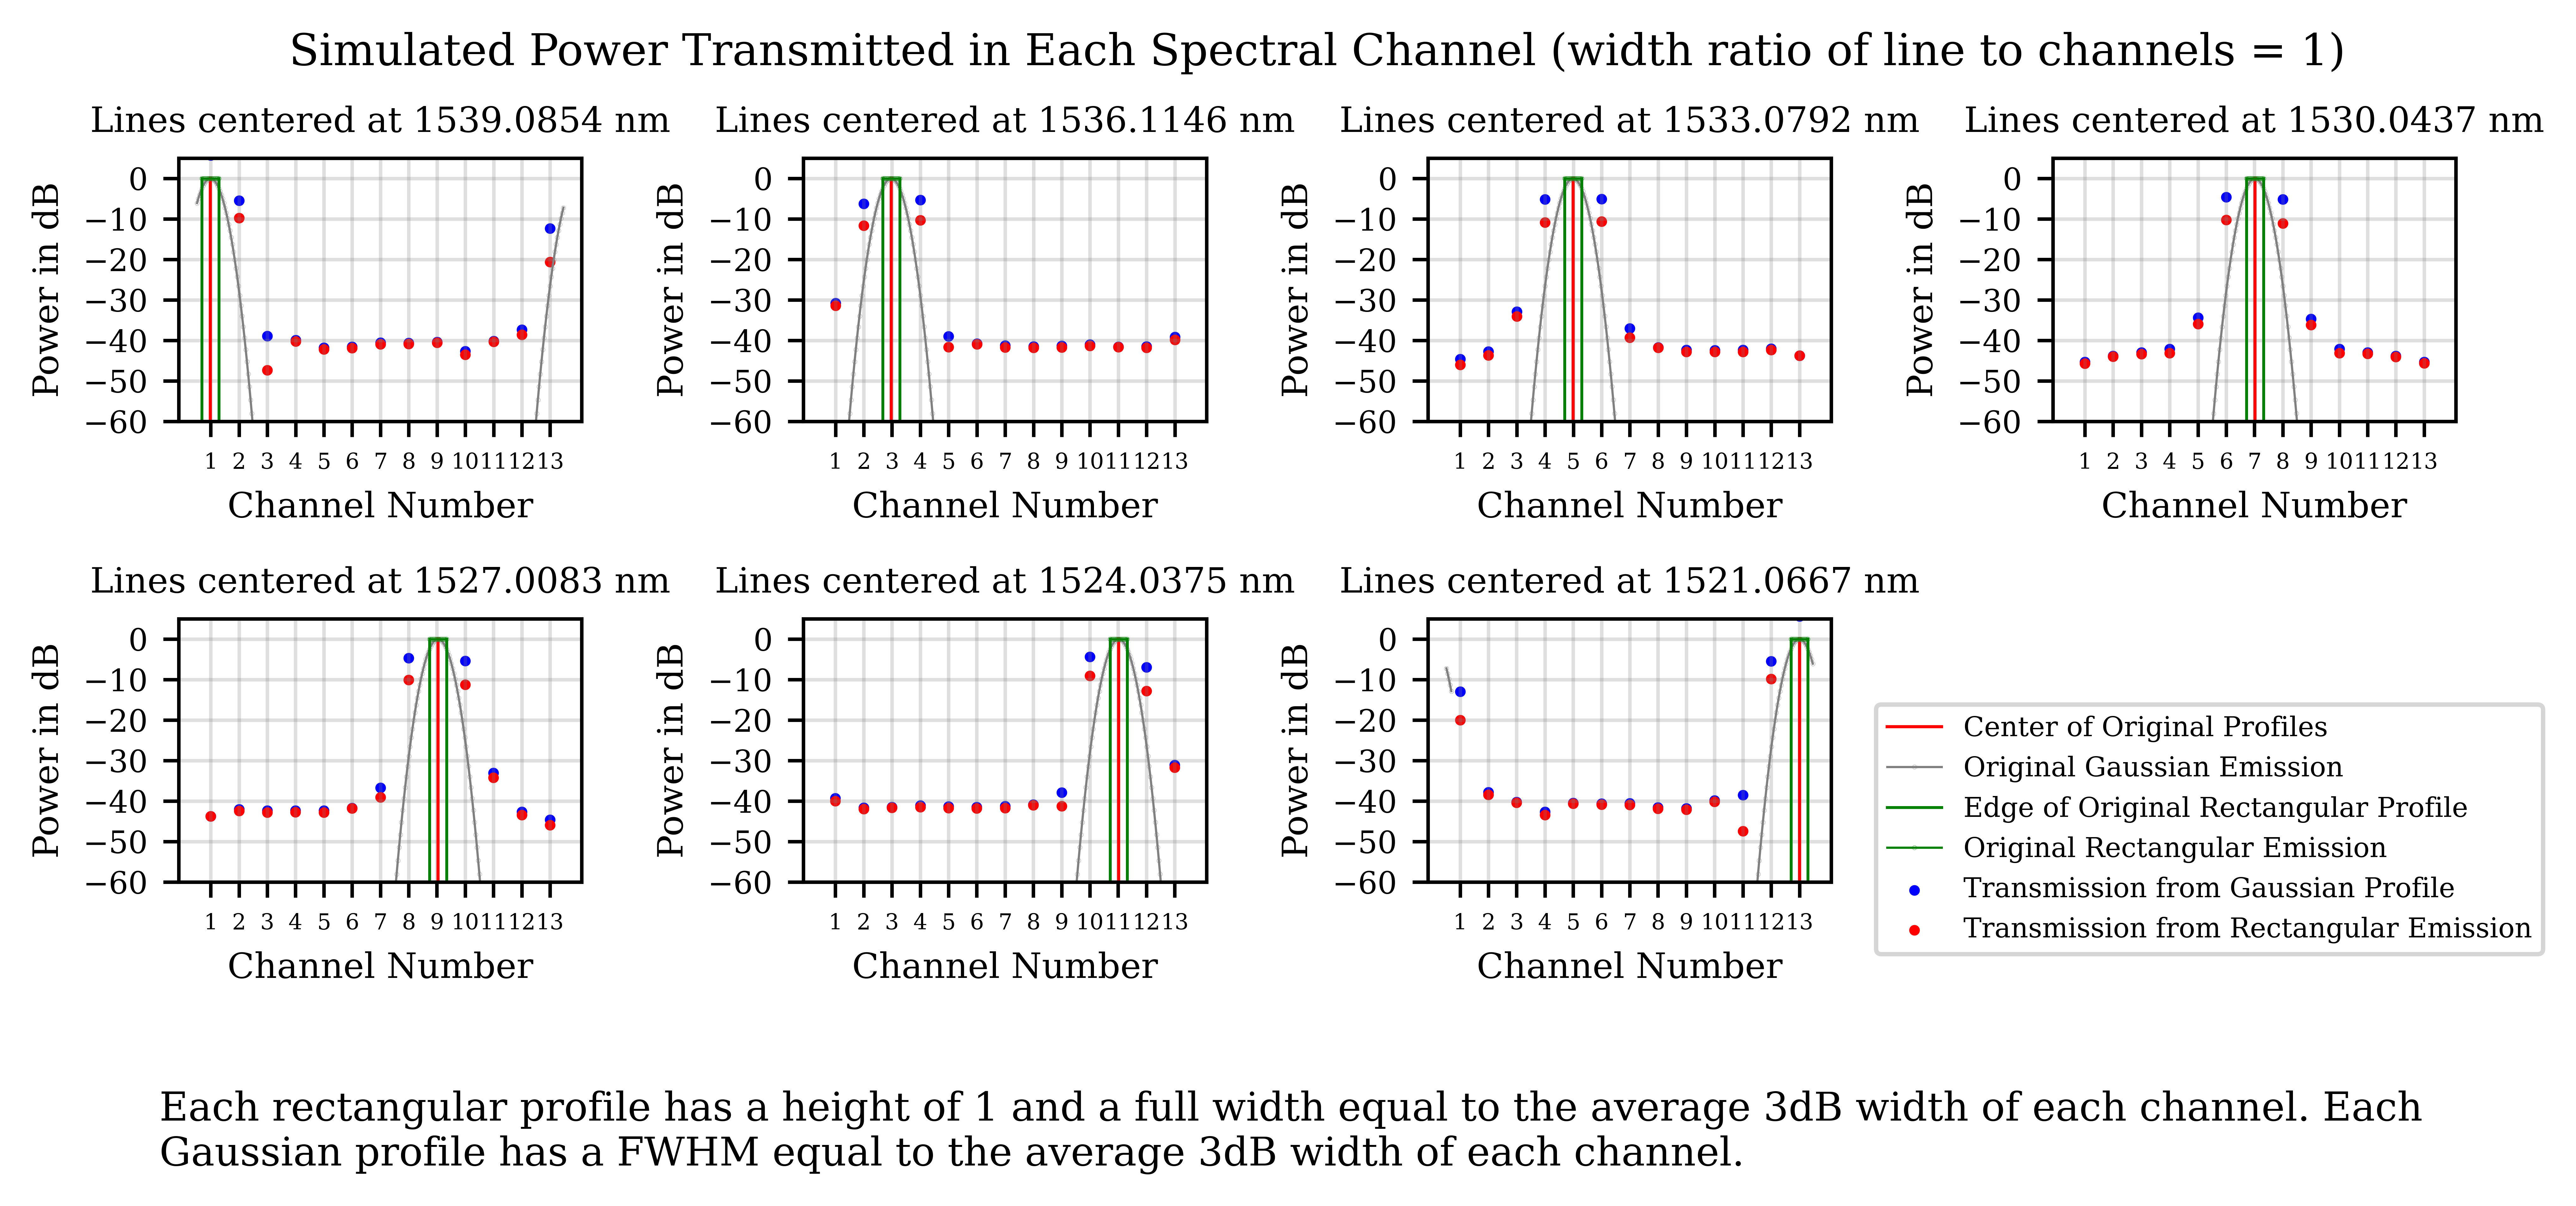

In [10]:
'''
let's plot the response for emission lines centered at the peak of different 
channels! We will use emission lines centered at the peak of channels 1, 3, 5, 7, and 9.
'''

#fig.text(0.5, 0.04, 'Channel Number', ha='center', fontsize = 'small')
#fig.text(0.04, 0.5, 'Power in dB', va='center', rotation='vertical', fontsize = 'small')
lam = np.array(df['0'])
FSR = 20
offset = 0 #shifting the emission line to the right of the peak by this many nanometers

fig = plt.figure(dpi = 1000)
gs = gridspec.GridSpec(4, 4)
#This is so that we can have 7 plots each take up 2 rows 
plt.subplots_adjust(wspace = .55, hspace = .75)
plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
for peak_channel in np.array((1, 3, 5, 7, 9, 11, 13)):
    plot_num = int(.5*(peak_channel-1))
    plot_indices = np.array((int(plot_num/4), plot_num%4))
    '''
    This two element array iterates through the subplot based on which channel we're choosing
    the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    #plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    xtick_size = 5
    ytick_size = 7
    xlabel_fontsize, ylabel_fontsize, title_fontsize = [8]*3
    point_label_size = 2
    op_power_norm_fib = np.array(df[str(peak_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peaks[1][0]+offset
    width_nanometers = 1
    height = 1
    symmetrical = True
    left_boundary = 0
    right_boundary = 0
    channels = np.array(list(range(1,14)))
    #Now we will make a dictionary to set the colors and labels for everything in the plot
    labels = 6
    plot_handles, plot_colors = [""]*labels, [""]*labels
    plot_handles[0] =  "Edge of Original Rectangular Profile" 
    plot_colors[0] = 'green'
    plot_handles[1] =  "Center of Original Profiles" 
    plot_colors[1] = 'red'
    plot_handles[2] = "Transmission from Gaussian Profile" 
    plot_colors[2] = 'blue'
    plot_handles[3] = "Original Gaussian Emission" 
    plot_colors[3] = 'grey' 
    plot_handles[4] = 'Transmission from Rectangular Emission'
    plot_colors[4] = 'red'
    plot_handles[5] = "Original Rectangular Emission" 
    plot_colors[5] = 'green'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_handles[i]] = plot_colors[i]
    #There are 13 channels but range will only go up to 1 before the second argument!
    plot_power_vs_channels(center_nanometers, width_nanometers, height, symmetrical, 
                        left_boundary, right_boundary, channels, plot_dict, True, ax1,
                        xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                        point_label_size, False)
    

#The legend will put at the top what was most recently plotted
#for i in list(range(len(plot_dict))):
#ax.lines[-1].set_label()
#handles, labels = ax1.get_legend_handles_labels()
ax1.legend(loc = "right", bbox_to_anchor=(2.8, .2), prop={'size': 6.2})
caption = "Each rectangular profile has a height of " + str(height) + " and a full width " 
if not (width_nanometers == 1):
    caption = caption + str(width_nanometers) + " times the average 3dB width of each channel."
    caption = caption + " Each " + "\n" + "Gaussian profile has a FWHM " + str(width_nanometers) + " times the "
else: 
    caption = caption + "equal to the average 3dB width of each channel."
    caption = caption + " Each " + "\n" + "Gaussian profile has a FWHM " + "equal to the "
caption = caption + "average 3dB width of each channel."
title = 'Simulated Power Transmitted in Each Spectral Channel'
title = title + ' (width ratio of line to channels = '+ str(width_nanometers) +')'
plt.suptitle(title, x=.3, y = 1, fontsize=10)
                                                                                        
'''
caption = "Figure 1: The simulated power transmitted by the spectrograph after being dispersed by "
caption = caption + "the Arrayed Waveguide Grating (AWG)\n" + "when observing a rectangular"
caption = caption + " emission line with a full width of .1" + " nanometers (nm)."
caption = caption + " Each emission line is centered at " 
if(offset == 0):
    caption = caption + "\n"
else:
    caption = caption + "a\n" + "wavelength "+ str(offset) + " nm longer than " 
caption = caption + "the peak of an odd numbered channel" 
caption = caption + " (channels 1, 3, 5, 7, 9, 11, and 13, respectively)."
'''
plt.text(x = -45, y = -130, s= caption, fontsize = 9)
#plt.show()

In [20]:
#Now to make a Gaussian fit of the transmission and get the FWHM to measure the resolving power!
'''
How do I make the x axis loop around? I need to center the channel I want to look at but how? 
Taken any channel further than 6 channels away from the chosen channel and move them to the opposite direction!
Check if there are any channels further than int(len(channels)/2) to the right. Move all the ones further than that
length to the left! Visa versa if there are no channels further than that length to the right. 
Make sure to only rearrange the integrated power array!

The function named center_chosen_channel rearranges the array of power transmission so that it is symmetrical
about channel 7. Note that this only works for emission lines centered at the peak wavelength of the channel!!
'''
def center_chosen_channel(chosen, channels, power):
    length = len(channels)
    halfway = int((len(channels)+1) / 2)
    #are there too many channels to the left or right? 
    num_far_channels = abs(chosen-halfway)
    #how many channels are too far to the left or right? 
    if any(channels > chosen + halfway) :
        power = power.tolist()
        channels = channels.tolist()
        for i in range(num_far_channels+1):
            far_channel = power[length-1]
            power.pop(length-1)
            power.insert(0, far_channel)
            channels.pop(length-1)
            channels.insert(0, i+halfway)
        power = np.array(power)
        channels = np.array(channels)

    elif(any(channels < chosen - halfway)):
        power = power.tolist()
        channels = channels.tolist()
        for i in range(num_far_channels+1):
            far_channel = power[length-1]
            power.pop(0)
            power.append(far_channel)
            channels.pop(0)
            channels.append(i+1)
        power = np.array(power)
        channels = np.array(channels)
        
    return (power, channels)

def re_sort_by_channels(rearranged_power, rearranged_channels):
    #put the channels and their transmission back in their original order to plot them!
    power = np.zeros(len(rearranged_channels))

    for index in range(len(rearranged_channels)):
        channel = int(rearranged_channels[index])-1
        power[channel] = rearranged_power[index] 
      #  print(channel, power[channel])
    #print(power)
    return power
    
def gauss(x,  *p):
    a, b, c, d = p
    y = a * np.exp(-np.power((x - b),2.) / (2. * c**2)) + d
    return y

def log_norm(x, *p):
    a, b, s, c = p
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
    #https://en.wikipedia.org/wiki/Log-normal_distribution
    y = a / (x * s) * np.exp(-np.power(np.log(x) - b, 2.) / (2. * s**2)) + c 
    return y

normalize = False
height = 1
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(list(range(1,14)))
normalize = False
shape = "Gaussian"
step_size = .3
largest_offset = 3
#different in nanometers betweent the wavelengths used for the center of the emission line in each plot
wavelengths = int((largest_offset  / step_size)+1)
#num is the number of plots we're making
offset_range = np.linspace(0, largest_offset , wavelengths)
FWHM_array_nm = np.array([0.]*wavelengths) #will be in nm
FWHM_array_channels = np.array([0.]*wavelengths)  #will be in channel widths
statistic_array = np.array([0.]*wavelengths)
'''
offset_range is the array of offsets in nm from the center the starting_channel, 
which is the spectral channel where the emission line in the first plot will be centered
'''
lam = np.array(df['0'])
FSR = 20
channels_for_plotting = np.array((6))
#cols = int(len(channels_for_plotting)/2)+1
cols = 4
rows = 3
#plt.subplots_adjust(wspace = .75*(cols/4), hspace = .75)
#plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
#for starting_channel in channels_for_plotting: 
#print("current channel is ", starting_channel)
starting_channel = 6
channels = np.array(list(range(1,14)))
xtick_size = 8
ytick_size = 9
xlabel_fontsize, ylabel_fontsize, title_fontsize = [11]*3
point_label_size = 2
line_width = .7
#This refers to a setting while plotting, NOT the width of the emission line in nm
marker_size = .1
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
#for center_nanometers in wavelengths:
rearrange = False
#keep False when plotting centermost channels
plt.figure(figsize = [int((wavelengths+2)*6/rows), 3*rows], dpi = 1200)
width_nanometers = 2
#This is the width of the emission line in nanometers!
gs = gridspec.GridSpec(rows, cols, wspace=.25, hspace = .4)
for offset in offset_range:
    op_power_norm_fib = np.array(df[str(starting_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peaks[1][0] - offset
    channels = np.array(list(range(1,14)))
    '''
    op_power_norm_fib = np.array(df[str(channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    offset = 0
    center_nanometers = peaks[1][0]+offset
    '''
    plot_num = int((offset/step_size))
    plot_indices = np.array((int(plot_num/cols), plot_num%cols))
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    ax1.set_ylim(-60, 15)
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    emission_line = Emission_line(center_nanometers, width_nanometers, height, shape, symmetrical, 
                            left_boundary, right_boundary, normalize)
    emission_line.calculate_power_vs_channels(channels)
    source_power = emission_line.source_power
    wavelengths = emission_line.wavelengths
    shortest_wavelength_channel = channels[len(channels)-1]
    #this is the channel we'll use to find out where to plot the red vertical line 
    #it will also help plot the original Gaussian and rectangular profiles
    op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
    peaks_for_x_values = find_3dB_width(lam, op_power_norm_fib, FSR)
    shortest_wavelength_peak = peaks_for_x_values[1][0]
    '''
    channel_x_values is an array of the wavelengths expressed in terms of channel number for
    the original Gaussian and rectangular profiles, not for the simulated transmission!
    '''
    channel_x_values = shortest_wavelength_channel-((wavelengths-shortest_wavelength_peak)/1.5)
    dB_power = 10 * np.log10(emission_line.integrated_power)
    source_power = 10 * np.log10(source_power)
    power = emission_line.integrated_power
    if shape == "Rectangular":
        original_label = "Original Rectangular Emission"
        original_color = "green"
    elif shape == "Gaussian":
        original_label = "Original Gaussian Emission"
        original_color = "grey"
    ax1.plot(channel_x_values, source_power, marker=".", linewidth = line_width,
                 markersize = marker_size, color = original_color, label = original_label)
    if (rearrange):
        original_dB_power = dB_power
        dB_power, rearranged_channels = center_chosen_channel(starting_channel, channels, dB_power)

    initial_guess = [np.amax(power) - np.amin(power), offset/1.5+starting_channel, 
                     1.5/2.355, np.amin(power)]
    optimized_values, covariance = curve_fit(f = gauss, xdata = channels, ydata = power, p0 = initial_guess)
    fit_x_values = np.linspace(channels[0], channels[len(channels)-1], 100)
    smooth_fit = 10 * np.log10(gauss(fit_x_values, *optimized_values))
    fitted_transmission = 10 * np.log10(gauss(channels, *optimized_values))
    line_x = shortest_wavelength_channel-((center_nanometers-shortest_wavelength_peak)/1.5)
    line_x = line_x % 13 #for emission lines outside of the spectral range
    if(line_x < .5): #for emission lines closer to channel 13 than channel 1
        line_x = line_x + 13
    y_max0 = 0.923076923 * 65 / 75
    y_max1, y_max2 = [0.923076923 * 65 / 75 * .995] * 2
    ax1.axvline(x = line_x, ymin = 0, ymax = y_max0, linestyle='solid', 
                color = "red", linewidth = .7, label = "Center of Emission Line")
    if (shape == "Rectangular"):
            ax1.axvline(x = channel_x_values[0], ymin = 0, ymax = y_max1, linestyle='solid', 
                        color = "green", linewidth = .65)
            ax1.axvline(x = channel_x_values[len(channel_x_values)-1], ymin = 0, ymax = y_max2, 
                        linestyle='solid', color = "green", linewidth = .65, 
                        label = "Edge of Rectangular Emission")
    ax1.scatter(channels, dB_power, label = "Simulated Transmission", s = point_label_size, color = "red")
    if (rearrange):
        sorted_fit = re_sort_by_channels(fitted_transmission, rearranged_channels) 
        ax1.plot(channels, original_dB_power, label = "Simulated Transmission", 
                 markersize = marker_size, linewidth = line_width)
        ax1.plot(fit_x_values, sorted_fit, label = "Gaussian Fit of Simulated Transmission", 
                 markersize = marker_size, linewidth = line_width)
    else:
        ax1.plot(fit_x_values, smooth_fit, label = "Gaussian Fit of Simulated Transmission", 
                markersize = marker_size, linewidth = line_width)
    #plt.legend(loc = "lower right", bbox_to_anchor=(1.75, .5))
    #plt.scatter(channels, ((fitted_transmission-dB_power)/dB_power)**2)
    xlabel = "Channel " 
    if rearrange:
        if (starting_channel-halfway < 0):
            xlabel = xlabel + "+" + str(abs(starting_channel+ 1 - halfway))
        elif(starting_channel-halfway > 0):
            xlabel = xlabel + "-" + str(starting_channel + 1 - halfway)
    ylabel = "Transmission in dB"
    ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize)
    ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize)
    title = "Line centered at " + str(np.around(center_nanometers, 4)) + " nm"
    ax1.set_title(title, fontsize = title_fontsize)
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60, 15, 10))))
    ax1.tick_params(axis='x', which='major', labelsize= xtick_size)
    ax1.tick_params(axis='y', which='major', labelsize= ytick_size)
    print("Maximum (Residuals / Transmission) :", np.amax(abs((fitted_transmission - dB_power)/dB_power)))
    print("Minimum (Residuals / Transmission) :", np.amin(abs((fitted_transmission - dB_power)/dB_power)))
    ax1.grid(which='major', color='grey', alpha=0.4)
    ax1.grid(which='minor', color='grey', alpha=0.1)
    ax1.minorticks_on()
    ax1.tick_params(axis='x', which='minor', bottom=False)
    ax1.xaxis.grid(False, which='minor')
    FWHM_channels = optimized_values[2]*2*math.sqrt(2*math.log(2)) #FWHM in channels
    FWHM_nm = FWHM_channels * FSR / len(channels) 
    #Convert FWHM from channel widths to nanometers
    index = int((offset)/step_size)
    FWHM_array_nm[index] = FWHM_nm
    FWHM_array_channels[index] = FWHM_channels
   
ax1.legend(loc = "lower center", bbox_to_anchor=(-.15, -1.5), prop={'size': 6.2*2.5})
ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]+1])
title = "Resolving Power of Photonic Spectrograph"
ax1.set_title(title, fontsize = title_fontsize)
ax1.scatter(offset_range/1.5+6, FWHM_array_nm, color = "green", s = point_label_size)
average_FWHM_nm = np.polyfit(offset_range/1.5+starting_channel, FWHM_array_nm, 0)
count = 3
fit_x_values = np.linspace(offset_range[0]/1.5+starting_channel, 
                            offset_range[len(offset_range)-1]/1.5+starting_channel, 100)
average_FWHM_nm = np.array([average_FWHM_nm]*len(fit_x_values))
ax1.plot(fit_x_values, average_FWHM_nm, label = "Average FWHM, y = " + 
         str(np.around(*average_FWHM_nm[0], 4)) + ' nm')
ax1.set_xlabel("Center of Emission Line (Channels)", fontsize = xlabel_fontsize)
ax1.set_ylabel("FWHM of Gaussian Fit (nm)", fontsize = ylabel_fontsize)
ax1.grid(which='major', color='grey', alpha=0.4)
ax1.grid(which='minor', color='grey', alpha=0.1)
ax1.minorticks_on()
ax1.legend(loc = "lower center", bbox_to_anchor=(.5, -1), prop={'size': 6.2*2.5})
title = 'Simulated Power Transmitted in Each Spectral Channel'
title = title + ' (ratio of line 3dB width to channel 3dB width = '+ str(width_nanometers) +')'
ax2 = ax1.twinx()
ax2.set_ylabel("Gaussian Fit FWHM (channel widths)")
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn * len(channels) / FSR, mx * len(channels) / FSR)
ax2.minorticks_on()
plt.suptitle(title, x = .5, y = .95, fontsize = 20)

Maximum (Residuals / Transmission) : 0.16723502737100754
Minimum (Residuals / Transmission) : 9.652740579766232e-12
Maximum (Residuals / Transmission) : 0.15465187771937391
Minimum (Residuals / Transmission) : 3.150022416338995e-10
Maximum (Residuals / Transmission) : 0.16940669337363415
Minimum (Residuals / Transmission) : 3.897553765843179e-08
Maximum (Residuals / Transmission) : 0.1598100229650658
Minimum (Residuals / Transmission) : 3.6484882594768504e-08
Maximum (Residuals / Transmission) : 0.1835896613631104
Minimum (Residuals / Transmission) : 3.160598571188734e-10
Maximum (Residuals / Transmission) : 0.13279858856690127
Minimum (Residuals / Transmission) : 9.796286071825404e-12
Maximum (Residuals / Transmission) : 0.18347769785726536
Minimum (Residuals / Transmission) : 3.0947932950136856e-10
Maximum (Residuals / Transmission) : 0.16026208644584036
Minimum (Residuals / Transmission) : 3.580009301933009e-08
Maximum (Residuals / Transmission) : 0.16877988488956647
Minimum (Residu

Text(0.5, 0.95, 'Simulated Power Transmitted in Each Spectral Channel (ratio of line 3dB width to channel 3dB width = 2)')

In [21]:
#Now to make a Gaussian fit of the transmission and get the FWHM to measure the resolving power!
'''
No plotting but still finding the average FWHM of the Gaussian fit for each of the different line widths
'''
normalize = False
height = 1
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(list(range(1,14)))
normalize = False
shape = "Gaussian"
step_size = .3
largest_offset = 3
#different in nanometers betweent the wavelengths used for the center of the emission line in each plot
wavelengths = int((largest_offset  / step_size)+1)
#num is the number of plots we're making
offset_range = np.linspace(0, largest_offset , wavelengths)
FWHM_array_nm = np.array([0.]*wavelengths) #will be in nm
FWHM_array_channels = np.array([0.]*wavelengths)  #will be in channel widths
statistic_array = np.array([0.]*wavelengths)
'''
offset_range is the array of offsets in nm from the center the starting_channel, 
which is the spectral channel where the emission line in the first plot will be centered
'''
lam = np.array(df['0'])
FSR = 20
channels_for_plotting = np.array((6))
#cols = int(len(channels_for_plotting)/2)+1
starting_channel = 6
channels = np.array(list(range(1,14)))
#This refers to a setting while plotting, NOT the width of the emission line in nm
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
#for center_nanometers in wavelengths:
rearrange = False
#keep False when plotting centermost channels
widths = np.linspace(.33, 8, 200)
FWHM_average_array = np.empty(shape = (2 , len(widths)))
for iteration in list(range(len(widths))):
    width_nanometers = widths[iteration]
    #This is the width of the emission line in nanometers!
    for offset in offset_range:
        center_nanometers = peaks[1][0] - offset
        channels = np.array(list(range(1,14)))
        emission_line = Emission_line(center_nanometers, width_nanometers, height, shape, symmetrical, 
                                left_boundary, right_boundary, normalize)
        emission_line.calculate_power_vs_channels(channels)
        source_power = emission_line.source_power
        wavelengths = emission_line.wavelengths
        shortest_wavelength_channel = channels[len(channels)-1]
        #this is the channel we'll use to find out where to plot the red vertical line 
        #it will also help plot the original Gaussian and rectangular profiles
        op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
        peaks_for_x_values = find_3dB_width(lam, op_power_norm_fib, FSR)
        shortest_wavelength_peak = peaks_for_x_values[1][0]
        '''
        channel_x_values is an array of the wavelengths expressed in terms of channel number for
        the original Gaussian and rectangular profiles, not for the simulated transmission!
        '''
        channel_x_values = shortest_wavelength_channel-((wavelengths-shortest_wavelength_peak)/1.5)
        dB_power = 10 * np.log10(emission_line.integrated_power)
        source_power = 10 * np.log10(source_power)
        power = emission_line.integrated_power
        if shape == "Rectangular":
            original_label = "Original Rectangular Emission"
            original_color = "green"
        elif shape == "Gaussian":
            original_label = "Original Gaussian Emission"
            original_color = "grey"
        ax1.plot(channel_x_values, source_power, marker=".", linewidth = line_width,
                     markersize = marker_size, color = original_color, label = original_label)
        if (rearrange):
            original_dB_power = dB_power
            dB_power, rearranged_channels = center_chosen_channel(starting_channel, channels, dB_power)

        initial_guess = [np.amax(power) - np.amin(power), offset/1.5+starting_channel, 
                         1.5/2.355, np.amin(power)]
        optimized_values, covariance = curve_fit(f = gauss, xdata = channels, ydata = power, p0 = initial_guess)
        fit_x_values = np.linspace(channels[0], channels[len(channels)-1], 100)
        smooth_fit = 10 * np.log10(gauss(fit_x_values, *optimized_values))
        fitted_transmission = 10 * np.log10(gauss(channels, *optimized_values))
        print("Maximum (Residuals / Transmission) :", np.amax(abs((fitted_transmission - dB_power)/dB_power)))
        print("Minimum (Residuals / Transmission) :", np.amin(abs((fitted_transmission - dB_power)/dB_power)))
        FWHM_channels = optimized_values[2]*2*math.sqrt(2*math.log(2)) #FWHM in channels
        FWHM_nm = FWHM_channels * FSR / len(channels) #Convert from FWHM in channel widths to nanometers
        index = int((offset)/step_size)
        FWHM_array_nm[index] = FWHM_nm
        FWHM_array_channels[index] = FWHM_channels
        
    average_FWHM_nm = np.polyfit(offset_range/1.5+starting_channel, FWHM_array_nm, 0)
    FWHM_average_array[[0],[iteration]] = width_nanometers
    FWHM_average_array[[1],[iteration]] = average_FWHM_nm

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.12887994128653457
Minimum (Residuals / Transmission) : 1.5072641547919785e-14
Maximum (Residuals / Transmission) : 0.15808041866664627
Minimum (Residuals / Transmission) : 6.549846159978181e-12
Maximum (Residuals / Transmission) : 0.18863810905959935
Minimum (Residuals / Transmission) : 4.426596963215567e-09
Maximum (Residuals / Transmission) : 0.17897575291162793
Minimum (Residuals / Transmission) : 2.747354806838834e-09
Maximum (Residuals / Transmission) : 0.16705546169143667
Minimum (Residuals / Transmission) : 4.545083649008828e-12
Maximum (Residuals / Transmission) : 0.10160079061614476
Minimum (Residuals / Transmission) : 1.1130064746575604e-14
Maximum (Residuals / Transmission) : 0.1647779586447152
Minimum (Residuals / Transmission) : 5.934997281173108e-12
Maximum (Residuals / Transmission) : 0.1824413421425332
Minimum (Residuals / Transmission) : 3.5769912561423228e-09
Maximum (Residuals / Transmission) : 0.1877451483647901
Minimum (Residu

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.13081662079896947
Minimum (Residuals / Transmission) : 1.0297570292684279e-14
Maximum (Residuals / Transmission) : 0.130443012964168
Minimum (Residuals / Transmission) : 1.1699883293478492e-14
Maximum (Residuals / Transmission) : 0.15847970774315878
Minimum (Residuals / Transmission) : 4.417880939051983e-12
Maximum (Residuals / Transmission) : 0.18924099521692606
Minimum (Residuals / Transmission) : 5.418585844895281e-09
Maximum (Residuals / Transmission) : 0.1807270719003634
Minimum (Residuals / Transmission) : 3.454499175604624e-09
Maximum (Residuals / Transmission) : 0.1685165080566696
Minimum (Residuals / Transmission) : 3.3020389995179037e-12
Maximum (Residuals / Transmission) : 0.10271802204687111
Minimum (Residuals / Transmission) : 2.3872932707144816e-14
Maximum (Residuals / Transmission) : 0.16658331999776313
Minimum (Residuals / Transmission) : 3.747440244445487e-12
Maximum (Residuals / Transmission) : 0.1836358801415972
Minimum (Residua

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

 0.1320578125192809
Minimum (Residuals / Transmission) : 9.735722750773393e-15
Maximum (Residuals / Transmission) : 0.13190889957559251
Minimum (Residuals / Transmission) : 1.0563823086791976e-14
Maximum (Residuals / Transmission) : 0.15876748810482194
Minimum (Residuals / Transmission) : 3.553963858629243e-12
Maximum (Residuals / Transmission) : 0.1896789364612445
Minimum (Residuals / Transmission) : 6.792855034762511e-09
Maximum (Residuals / Transmission) : 0.18225804664737935
Minimum (Residuals / Transmission) : 4.463598189483362e-09
Maximum (Residuals / Transmission) : 0.16991721361118706
Minimum (Residuals / Transmission) : 2.6459659339269473e-12
Maximum (Residuals / Transmission) : 0.10377506074209177
Minimum (Residuals / Transmission) : 1.930244846780345e-14
Maximum (Residuals / Transmission) : 0.16823952893945765
Minimum (Residuals / Transmission) : 2.704440632780115e-12
Maximum (Residuals / Transmission) : 0.18475590695298008
Minimum (Residuals / Transmission) : 5.875764140484

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.15841092340151852
Minimum (Residuals / Transmission) : 3.4199606045983732e-12
Maximum (Residuals / Transmission) : 0.1344962756399386
Minimum (Residuals / Transmission) : 8.701498142621052e-15
Maximum (Residuals / Transmission) : 0.1346184547538914
Minimum (Residuals / Transmission) : 1.2523540333145783e-13
Maximum (Residuals / Transmission) : 0.15903722008861632
Minimum (Residuals / Transmission) : 2.8469510796914e-12
Maximum (Residuals / Transmission) : 0.1900906286720059
Minimum (Residuals / Transmission) : 1.2000361736783308e-08
Maximum (Residuals / Transmission) : 0.1847508821525038
Minimum (Residuals / Transmission) : 8.62992086343795e-09
Maximum (Residuals / Transmission) : 0.17251683219081598
Minimum (Residuals / Transmission) : 2.0905592782170447e-12
Maximum (Residuals / Transmission) : 0.10574424220540315
Minimum (Residuals / Transmission) : 1.3274063395851272e-14
Maximum (Residuals / Transmission) : 0.17118773960634362
Minimum (Residual

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18957543152599282
Minimum (Residuals / Transmission) : 1.1375834464592283e-08
Maximum (Residuals / Transmission) : 0.15856829212403178
Minimum (Residuals / Transmission) : 3.058543452686205e-12
Maximum (Residuals / Transmission) : 0.1356804235743393
Minimum (Residuals / Transmission) : 3.360422849570259e-13
Maximum (Residuals / Transmission) : 0.1358859993534305
Minimum (Residuals / Transmission) : 9.27313540316319e-15
Maximum (Residuals / Transmission) : 0.15903819701170596
Minimum (Residuals / Transmission) : 2.710716248682156e-12
Maximum (Residuals / Transmission) : 0.19008325818175548
Minimum (Residuals / Transmission) : 1.778826228958231e-08
Maximum (Residuals / Transmission) : 0.1857448877563587
Minimum (Residuals / Transmission) : 1.3982130136502527e-08
Maximum (Residuals / Transmission) : 0.17371682042792908
Minimum (Residuals / Transmission) : 1.994341441818266e-12
Maximum (Residuals / Transmission) : 0.10667067022163225
Minimum (Residual

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18749821176552822
Minimum (Residuals / Transmission) : 1.8676774683911405e-08
Maximum (Residuals / Transmission) : 0.1896039452614453
Minimum (Residuals / Transmission) : 1.6491908792471204e-08
Maximum (Residuals / Transmission) : 0.15862481750645172
Minimum (Residuals / Transmission) : 2.8678051926257334e-12
Maximum (Residuals / Transmission) : 0.13683893302171576
Minimum (Residuals / Transmission) : 2.359447202798315e-13
Maximum (Residuals / Transmission) : 0.13710659874256592
Minimum (Residuals / Transmission) : 9.489084617532651e-15
Maximum (Residuals / Transmission) : 0.15896326247319806
Minimum (Residuals / Transmission) : 2.650265858017118e-12
Maximum (Residuals / Transmission) : 0.18994762368200643
Minimum (Residuals / Transmission) : 2.5204867778673623e-08
Maximum (Residuals / Transmission) : 0.18658565355793458
Minimum (Residuals / Transmission) : 1.98890592222114e-08
Maximum (Residuals / Transmission) : 0.17485398104858235
Minimum (Resi

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18818622301570279
Minimum (Residuals / Transmission) : 2.021763268663864e-08
Maximum (Residuals / Transmission) : 0.18949377655626787
Minimum (Residuals / Transmission) : 2.5388798248830955e-08
Maximum (Residuals / Transmission) : 0.1585949684917155
Minimum (Residuals / Transmission) : 2.776589641122842e-12
Maximum (Residuals / Transmission) : 0.13797205100272206
Minimum (Residuals / Transmission) : 1.6665295168826774e-13
Maximum (Residuals / Transmission) : 0.1382862993319538
Minimum (Residuals / Transmission) : 1.0166885978268253e-14
Maximum (Residuals / Transmission) : 0.15882207954737051
Minimum (Residuals / Transmission) : 2.646506013416346e-12
Maximum (Residuals / Transmission) : 0.18969442415522483
Minimum (Residuals / Transmission) : 2.7308389029905438e-08
Maximum (Residuals / Transmission) : 0.18728103008300506
Minimum (Residuals / Transmission) : 2.1655957183069696e-08
Maximum (Residuals / Transmission) : 0.1759318469115954
Minimum (Resi

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.10927921430756701
Minimum (Residuals / Transmission) : 1.111515018948139e-14
Maximum (Residuals / Transmission) : 0.17600052168834937
Minimum (Residuals / Transmission) : 2.0134403256670676e-12
Maximum (Residuals / Transmission) : 0.18921312905870674
Minimum (Residuals / Transmission) : 1.8700143619484783e-08
Maximum (Residuals / Transmission) : 0.1889116067688543
Minimum (Residuals / Transmission) : 2.9934632835686813e-08
Maximum (Residuals / Transmission) : 0.15832446584071794
Minimum (Residuals / Transmission) : 2.787417710337093e-12
Maximum (Residuals / Transmission) : 0.14016547999769166
Minimum (Residuals / Transmission) : 1.0209670038166918e-14
Maximum (Residuals / Transmission) : 0.1405410421751705
Minimum (Residuals / Transmission) : 2.361445223638929e-15
Maximum (Residuals / Transmission) : 0.15837678603045122
Minimum (Residuals / Transmission) : 2.775087380484889e-12
Maximum (Residuals / Transmission) : 0.18887737771756602
Minimum (Resi

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18977104600792272
Minimum (Residuals / Transmission) : 1.049789686720457e-08
Maximum (Residuals / Transmission) : 0.18792906095945852
Minimum (Residuals / Transmission) : 2.8186151162363395e-08
Maximum (Residuals / Transmission) : 0.15783990345615764
Minimum (Residuals / Transmission) : 2.9869215437491327e-12
Maximum (Residuals / Transmission) : 0.14226849632877425
Minimum (Residuals / Transmission) : 4.416761630463816e-14
Maximum (Residuals / Transmission) : 0.14267779247668022
Minimum (Residuals / Transmission) : 4.66671832771573e-15
Maximum (Residuals / Transmission) : 0.15776769472010888
Minimum (Residuals / Transmission) : 3.0599510753726238e-12
Maximum (Residuals / Transmission) : 0.18771380731800247
Minimum (Residuals / Transmission) : 1.9019055891199254e-08
Maximum (Residuals / Transmission) : 0.18870242613398278
Minimum (Residuals / Transmission) : 1.0804878875297928e-08
Maximum (Residuals / Transmission) : 0.17972018593428818
Minimum (Re

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)


Maximum (Residuals / Transmission) : 0.17892062826898933
Minimum (Residuals / Transmission) : 2.3445626298910145e-12
Maximum (Residuals / Transmission) : 0.18987238419289723
Minimum (Residuals / Transmission) : 9.007275181421432e-09
Maximum (Residuals / Transmission) : 0.18731579937222093
Minimum (Residuals / Transmission) : 2.080761837250466e-08
Maximum (Residuals / Transmission) : 0.15753873387877132
Minimum (Residuals / Transmission) : 3.1497592351222023e-12
Maximum (Residuals / Transmission) : 0.14328843104542546
Minimum (Residuals / Transmission) : 3.437550354166991e-14
Maximum (Residuals / Transmission) : 0.14370774704557918
Minimum (Residuals / Transmission) : 8.282942495651307e-15
Maximum (Residuals / Transmission) : 0.15741947831047431
Minimum (Residuals / Transmission) : 3.2645456613704027e-12


<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18702658528018648
Minimum (Residuals / Transmission) : 1.5786332944753428e-08
Maximum (Residuals / Transmission) : 0.18872969624011857
Minimum (Residuals / Transmission) : 9.374422801230149e-09
Maximum (Residuals / Transmission) : 0.18055242377137437
Minimum (Residuals / Transmission) : 2.5959142950530864e-12
Maximum (Residuals / Transmission) : 0.11248043949817112
Minimum (Residuals / Transmission) : 1.4203110020478503e-14
Maximum (Residuals / Transmission) : 0.179791200382882
Minimum (Residuals / Transmission) : 2.52289552600589e-12
Maximum (Residuals / Transmission) : 0.1898537935458901
Minimum (Residuals / Transmission) : 8.07792170147862e-09
Maximum (Residuals / Transmission) : 0.18663506944515293
Minimum (Residuals / Transmission) : 1.700423181741362e-08
Maximum (Residuals / Transmission) : 0.1572081275871741
Minimum (Residuals / Transmission) : 3.76047142722961e-12
Maximum (Residuals / Transmission) : 0.14428837696498287
Minimum (Residuals 

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.15666628104897087
Minimum (Residuals / Transmission) : 3.816507545172557e-12
Maximum (Residuals / Transmission) : 0.1854885154017701
Minimum (Residuals / Transmission) : 1.251804160704059e-08
Maximum (Residuals / Transmission) : 0.18839391972647715
Minimum (Residuals / Transmission) : 7.904866935462688e-09
Maximum (Residuals / Transmission) : 0.18209853764680026
Minimum (Residuals / Transmission) : 3.0979933571345767e-12
Maximum (Residuals / Transmission) : 0.11399919834053679
Minimum (Residuals / Transmission) : 1.7879523951489424e-14
Maximum (Residuals / Transmission) : 0.18140077112251213
Minimum (Residuals / Transmission) : 3.0024787452114963e-12
Maximum (Residuals / Transmission) : 0.18945012636355982
Minimum (Residuals / Transmission) : 7.0758889586415486e-09
Maximum (Residuals / Transmission) : 0.18511004741871667
Minimum (Residuals / Transmission) : 1.326804669444426e-08
Maximum (Residuals / Transmission) : 0.15648416328025042
Minimum (Res

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.14666236876556793
Minimum (Residuals / Transmission) : 1.9856922955835955e-14
Maximum (Residuals / Transmission) : 0.15627202201015125
Minimum (Residuals / Transmission) : 4.16910494676411e-12
Maximum (Residuals / Transmission) : 0.1846559473678628
Minimum (Residuals / Transmission) : 1.1639592916874588e-08
Maximum (Residuals / Transmission) : 0.18802895327277008
Minimum (Residuals / Transmission) : 7.529958924400316e-09
Maximum (Residuals / Transmission) : 0.18281722633093217
Minimum (Residuals / Transmission) : 3.494293785330303e-12
Maximum (Residuals / Transmission) : 0.1147424578363826
Minimum (Residuals / Transmission) : 2.0745583730277636e-14
Maximum (Residuals / Transmission) : 0.1821459562231014
Minimum (Residuals / Transmission) : 3.314740886730583e-12
Maximum (Residuals / Transmission) : 0.18906078094564785
Minimum (Residuals / Transmission) : 6.821901986787155e-09
Maximum (Residuals / Transmission) : 0.18428424674560914
Minimum (Residua

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.14760577731621527
Minimum (Residuals / Transmission) : 2.4027874016290654e-14
Maximum (Residuals / Transmission) : 0.1562455161497076
Minimum (Residuals / Transmission) : 4.590435130007912e-12
Maximum (Residuals / Transmission) : 0.18379282527826196
Minimum (Residuals / Transmission) : 1.103614339214901e-08
Maximum (Residuals / Transmission) : 0.1875303887555596
Minimum (Residuals / Transmission) : 7.297408082975954e-09
Maximum (Residuals / Transmission) : 0.18350259672032274
Minimum (Residuals / Transmission) : 3.809237918347905e-12
Maximum (Residuals / Transmission) : 0.115476064120819
Minimum (Residuals / Transmission) : 2.4381484497329873e-14
Maximum (Residuals / Transmission) : 0.18285505441976885
Minimum (Residuals / Transmission) : 3.684973832910102e-12
Maximum (Residuals / Transmission) : 0.18854297600832254
Minimum (Residuals / Transmission) : 6.673225650990659e-09
Maximum (Residuals / Transmission) : 0.1834280337546843
Minimum (Residuals

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.14810032411887758
Minimum (Residuals / Transmission) : 2.8090252760211786e-14
Maximum (Residuals / Transmission) : 0.1485298315977504
Minimum (Residuals / Transmission) : 2.934731443669488e-14
Maximum (Residuals / Transmission) : 0.15685429764395323
Minimum (Residuals / Transmission) : 5.086771581217052e-12
Maximum (Residuals / Transmission) : 0.1829076626560765
Minimum (Residuals / Transmission) : 1.062775735116703e-08
Maximum (Residuals / Transmission) : 0.18689594307727617
Minimum (Residuals / Transmission) : 7.171347502136764e-09
Maximum (Residuals / Transmission) : 0.18415665260620975
Minimum (Residuals / Transmission) : 4.265671923320354e-12
Maximum (Residuals / Transmission) : 0.11620065412739677
Minimum (Residuals / Transmission) : 2.8301568564663173e-14
Maximum (Residuals / Transmission) : 0.18353047694276464
Minimum (Residuals / Transmission) : 4.126547561357461e-12
Maximum (Residuals / Transmission) : 0.18789369573932882
Minimum (Residu

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.15682325276782194
Minimum (Residuals / Transmission) : 5.21967541520404e-12
Maximum (Residuals / Transmission) : 0.14900873139850293
Minimum (Residuals / Transmission) : 3.1517424820629815e-14
Maximum (Residuals / Transmission) : 0.14943518348435814
Minimum (Residuals / Transmission) : 3.473395846049904e-14
Maximum (Residuals / Transmission) : 0.15743367700064625
Minimum (Residuals / Transmission) : 5.67129529010522e-12
Maximum (Residuals / Transmission) : 0.18200866270538726
Minimum (Residuals / Transmission) : 1.0365933782812665e-08
Maximum (Residuals / Transmission) : 0.1861228971343697
Minimum (Residuals / Transmission) : 7.1298468741485635e-09
Maximum (Residuals / Transmission) : 0.18478121959758104
Minimum (Residuals / Transmission) : 4.806506789124035e-12
Maximum (Residuals / Transmission) : 0.11691675081986183
Minimum (Residuals / Transmission) : 3.3637146754826333e-14
Maximum (Residuals / Transmission) : 0.1841744092609703
Minimum (Residu

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.11762478621197736
Minimum (Residuals / Transmission) : 4.016803408850612e-14
Maximum (Residuals / Transmission) : 0.1847888037626249
Minimum (Residuals / Transmission) : 5.263954083512578e-12
Maximum (Residuals / Transmission) : 0.18618695908062194
Minimum (Residuals / Transmission) : 6.671034141508722e-09
Maximum (Residuals / Transmission) : 0.18075956428761805
Minimum (Residuals / Transmission) : 1.067068444330627e-08
Maximum (Residuals / Transmission) : 0.1579636625090375
Minimum (Residuals / Transmission) : 6.5216232407306356e-12
Maximum (Residuals / Transmission) : 0.15077471817149118
Minimum (Residuals / Transmission) : 4.320614496215407e-14
Maximum (Residuals / Transmission) : 0.1511920383514736
Minimum (Residuals / Transmission) : 5.0464085379538024e-14
Maximum (Residuals / Transmission) : 0.1585087676521722
Minimum (Residuals / Transmission) : 7.170039791189182e-12
Maximum (Residuals / Transmission) : 0.18020021581438944
Minimum (Residual

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18414815091647585
Minimum (Residuals / Transmission) : 7.250701866877192e-09
Maximum (Residuals / Transmission) : 0.18594828603065489
Minimum (Residuals / Transmission) : 6.199663102108286e-12
Maximum (Residuals / Transmission) : 0.1183251250566899
Minimum (Residuals / Transmission) : 4.810896503600029e-14
Maximum (Residuals / Transmission) : 0.18537536384565795
Minimum (Residuals / Transmission) : 5.996223045822165e-12
Maximum (Residuals / Transmission) : 0.1851218440309125
Minimum (Residuals / Transmission) : 6.786246735831997e-09
Maximum (Residuals / Transmission) : 0.17986263783994524
Minimum (Residuals / Transmission) : 1.0602539040991353e-08
Maximum (Residuals / Transmission) : 0.15849126826553345
Minimum (Residuals / Transmission) : 7.35286911403317e-12
Maximum (Residuals / Transmission) : 0.15163296981024868
Minimum (Residuals / Transmission) : 5.1842621420861065e-14
Maximum (Residuals / Transmission) : 0.15204456374462796
Minimum (Residua

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.159478266434651
Minimum (Residuals / Transmission) : 9.250809552459632e-12
Maximum (Residuals / Transmission) : 0.17842562735529524
Minimum (Residuals / Transmission) : 1.0312499232549792e-08
Maximum (Residuals / Transmission) : 0.18157687123436964
Minimum (Residuals / Transmission) : 7.602940718738552e-09
Maximum (Residuals / Transmission) : 0.18701423734141057
Minimum (Residuals / Transmission) : 8.158908204579898e-12
Maximum (Residuals / Transmission) : 0.11970391018447252
Minimum (Residuals / Transmission) : 7.113486041201629e-14
Maximum (Residuals / Transmission) : 0.18647036953236482
Minimum (Residuals / Transmission) : 7.895484885184022e-12
Maximum (Residuals / Transmission) : 0.18254680995881273
Minimum (Residuals / Transmission) : 7.167489556914622e-09
Maximum (Residuals / Transmission) : 0.17810005371933946
Minimum (Residuals / Transmission) : 1.0724946920798407e-08
Maximum (Residuals / Transmission) : 0.1594657760630605
Minimum (Residua

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.15330165689631117
Minimum (Residuals / Transmission) : 7.559099744578802e-14
Maximum (Residuals / Transmission) : 0.15370018850703704
Minimum (Residuals / Transmission) : 9.02977451370626e-14
Maximum (Residuals / Transmission) : 0.1599247697534065
Minimum (Residuals / Transmission) : 1.05809686124314e-11
Maximum (Residuals / Transmission) : 0.17756727291350977
Minimum (Residuals / Transmission) : 1.0491654907453231e-08
Maximum (Residuals / Transmission) : 0.18005699455641602
Minimum (Residuals / Transmission) : 7.860404881262502e-09
Maximum (Residuals / Transmission) : 0.1875112792873337
Minimum (Residuals / Transmission) : 9.422731897711046e-12
Maximum (Residuals / Transmission) : 0.12038288050257744
Minimum (Residuals / Transmission) : 8.692111841330573e-14
Maximum (Residuals / Transmission) : 0.18698064595946787
Minimum (Residuals / Transmission) : 9.121992070906227e-12
Maximum (Residuals / Transmission) : 0.18102759353744247
Minimum (Residuals

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.177246998579972
Minimum (Residuals / Transmission) : 1.0900694402392246e-08
Maximum (Residuals / Transmission) : 0.15991364520006796
Minimum (Residuals / Transmission) : 1.086007896275795e-11
Maximum (Residuals / Transmission) : 0.15411278716959442
Minimum (Residuals / Transmission) : 9.248077443318415e-14
Maximum (Residuals / Transmission) : 0.15450421092895497
Minimum (Residuals / Transmission) : 1.108072168938016e-13
Maximum (Residuals / Transmission) : 0.1603458169609323
Minimum (Residuals / Transmission) : 1.2154982747955347e-11
Maximum (Residuals / Transmission) : 0.17673589513671406
Minimum (Residuals / Transmission) : 1.07390520346763e-08
Maximum (Residuals / Transmission) : 0.17837484357781963
Minimum (Residuals / Transmission) : 8.172720514646929e-09
Maximum (Residuals / Transmission) : 0.1879846239750922
Minimum (Residuals / Transmission) : 1.0927551296545868e-11
Maximum (Residuals / Transmission) : 0.1210552231834852
Minimum (Residuals

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.16033525981637245
Minimum (Residuals / Transmission) : 1.2481095790862869e-11
Maximum (Residuals / Transmission) : 0.15490892848282348
Minimum (Residuals / Transmission) : 1.1377717022835023e-13
Maximum (Residuals / Transmission) : 0.15529298453902535
Minimum (Residuals / Transmission) : 1.3673452762205195e-13
Maximum (Residuals / Transmission) : 0.16074082438887918
Minimum (Residuals / Transmission) : 1.4021376085666005e-11
Maximum (Residuals / Transmission) : 0.17593659545658766
Minimum (Residuals / Transmission) : 1.1054517546041161e-08
Maximum (Residuals / Transmission) : 0.17652561870745143
Minimum (Residuals / Transmission) : 8.54205765639551e-09
Maximum (Residuals / Transmission) : 0.18843378877631486
Minimum (Residuals / Transmission) : 1.2722207732517661e-11
Maximum (Residuals / Transmission) : 0.12172116536479063
Minimum (Residuals / Transmission) : 1.6933463763377026e-13
Maximum (Residuals / Transmission) : 0.18792795948298413
Minimum (

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.1607299695344891
Minimum (Residuals / Transmission) : 1.4403679066516483e-11
Maximum (Residuals / Transmission) : 0.15569046378685839
Minimum (Residuals / Transmission) : 1.403274634491346e-13
Maximum (Residuals / Transmission) : 0.1560669688849606
Minimum (Residuals / Transmission) : 1.6926100553801593e-13
Maximum (Residuals / Transmission) : 0.16110857227085343
Minimum (Residuals / Transmission) : 1.6237339064247243e-11
Maximum (Residuals / Transmission) : 0.17517390935062366
Minimum (Residuals / Transmission) : 1.143958037275257e-08
Maximum (Residuals / Transmission) : 0.1745044404551927
Minimum (Residuals / Transmission) : 8.971765974891755e-09
Maximum (Residuals / Transmission) : 0.18885762521850996
Minimum (Residuals / Transmission) : 1.4864712067667782e-11
Maximum (Residuals / Transmission) : 0.12238093817276952
Minimum (Residuals / Transmission) : 1.8455064743909977e-13


<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.18836372153592448
Minimum (Residuals / Transmission) : 1.4410517045136373e-11
Maximum (Residuals / Transmission) : 0.1754836189469334
Minimum (Residuals / Transmission) : 8.54764949021204e-09
Maximum (Residuals / Transmission) : 0.1748656973290585
Minimum (Residuals / Transmission) : 1.1858506312271661e-08
Maximum (Residuals / Transmission) : 0.1610964424528363
Minimum (Residuals / Transmission) : 1.6689459836121424e-11
Maximum (Residuals / Transmission) : 0.1564577868081871
Minimum (Residuals / Transmission) : 1.7394344090173844e-13
Maximum (Residuals / Transmission) : 0.15682661562700664
Minimum (Residuals / Transmission) : 2.1038591072000632e-13
Maximum (Residuals / Transmission) : 0.16144703203594504
Minimum (Residuals / Transmission) : 1.887400734035285e-11
Maximum (Residuals / Transmission) : 0.17445180193444618
Minimum (Residuals / Transmission) : 1.1897287831594284e-08
Maximum (Residuals / Transmission) : 0.17230649573543405
Minimum (Resid

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.12303477200048915
Minimum (Residuals / Transmission) : 2.1668965392008666e-13
Maximum (Residuals / Transmission) : 0.18877209652354401
Minimum (Residuals / Transmission) : 1.6904171468619506e-11
Maximum (Residuals / Transmission) : 0.17328999568067074
Minimum (Residuals / Transmission) : 9.038201060784592e-09
Maximum (Residuals / Transmission) : 0.1741459983484003
Minimum (Residuals / Transmission) : 1.2325482967754115e-08
Maximum (Residuals / Transmission) : 0.1614325072232229
Minimum (Residuals / Transmission) : 1.9409527843912417e-11
Maximum (Residuals / Transmission) : 0.15721130068400133
Minimum (Residuals / Transmission) : 2.1709515255900135e-13
Maximum (Residuals / Transmission) : 0.1575723648960855
Minimum (Residuals / Transmission) : 2.6263469595219995e-13
Maximum (Residuals / Transmission) : 0.16175320671270035
Minimum (Residuals / Transmission) : 2.2016986522805e-11
Maximum (Residuals / Transmission) : 0.1737736418143054
Minimum (Residu

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.1699271570081246
Minimum (Residuals / Transmission) : 1.0031392225736272e-08
Maximum (Residuals / Transmission) : 0.18962041340445773
Minimum (Residuals / Transmission) : 2.050162996981391e-11
Maximum (Residuals / Transmission) : 0.12368289517326572
Minimum (Residuals / Transmission) : 2.64407681381012e-13
Maximum (Residuals / Transmission) : 0.1891503027791374
Minimum (Residuals / Transmission) : 1.989546028305532e-11
Maximum (Residuals / Transmission) : 0.1709154321075534
Minimum (Residuals / Transmission) : 9.597001315101842e-09
Maximum (Residuals / Transmission) : 0.17346923784281318
Minimum (Residuals / Transmission) : 1.28724442537704e-08
Maximum (Residuals / Transmission) : 0.16173496440206445
Minimum (Residuals / Transmission) : 2.2653823525217898e-11
Maximum (Residuals / Transmission) : 0.15795140153462642
Minimum (Residuals / Transmission) : 2.712969332784031e-13
Maximum (Residuals / Transmission) : 0.1583046327372192
Minimum (Residuals 

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.1620229171148999
Minimum (Residuals / Transmission) : 2.5767464251732475e-11
Maximum (Residuals / Transmission) : 0.1731421905834021
Minimum (Residuals / Transmission) : 1.3049925793434898e-08
Maximum (Residuals / Transmission) : 0.16736216379932664
Minimum (Residuals / Transmission) : 1.0673740202543648e-08
Maximum (Residuals / Transmission) : 0.18995226735208773
Minimum (Residuals / Transmission) : 2.4187071650645266e-11
Maximum (Residuals / Transmission) : 0.12432553432766273
Minimum (Residuals / Transmission) : 3.271885077301297e-13
Maximum (Residuals / Transmission) : 0.18949439148467218
Minimum (Residuals / Transmission) : 2.3485063737675833e-11
Maximum (Residuals / Transmission) : 0.168355581974635
Minimum (Residuals / Transmission) : 1.0230994475897041e-08
Maximum (Residuals / Transmission) : 0.1728380125674499
Minimum (Residuals / Transmission) : 1.3505276500687167e-08
Maximum (Residuals / Transmission) : 0.16199938235307804
Minimum (Resi

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.15902379796534305
Minimum (Residuals / Transmission) : 4.864200316378814e-13
Maximum (Residuals / Transmission) : 0.16225058815113755
Minimum (Residuals / Transmission) : 3.0252994809587904e-11
Maximum (Residuals / Transmission) : 0.17255960405677628
Minimum (Residuals / Transmission) : 1.3758008063552329e-08
Maximum (Residuals / Transmission) : 0.16460785366550545
Minimum (Residuals / Transmission) : 1.1401420040111793e-08
Maximum (Residuals / Transmission) : 0.1902441969531632
Minimum (Residuals / Transmission) : 2.861492111893273e-11
Maximum (Residuals / Transmission) : 0.12496289596263374
Minimum (Residuals / Transmission) : 4.104733822844045e-13
Maximum (Residuals / Transmission) : 0.18979904615234197
Minimum (Residuals / Transmission) : 2.7799952741177118e-11
Maximum (Residuals / Transmission) : 0.16560673600884543
Minimum (Residuals / Transmission) : 1.0948333727502872e-08
Maximum (Residuals / Transmission) : 0.17225429379663615
Minimum (Re

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero en

Maximum (Residuals / Transmission) : 0.16221987913754288
Minimum (Residuals / Transmission) : 3.116501775464291e-11
Maximum (Residuals / Transmission) : 0.15939285397691286
Minimum (Residuals / Transmission) : 5.791852092267141e-13
Maximum (Residuals / Transmission) : 0.15973018298400482
Minimum (Residuals / Transmission) : 5.363745170568031e-13
Maximum (Residuals / Transmission) : 0.16242903417499852
Minimum (Residuals / Transmission) : 3.562406658662597e-11
Maximum (Residuals / Transmission) : 0.17202743736907275
Minimum (Residuals / Transmission) : 1.4565117554592648e-08
Maximum (Residuals / Transmission) : 0.16166138500451002
Minimum (Residuals / Transmission) : 1.2223805948094784e-08
Maximum (Residuals / Transmission) : 0.1904890910341345
Minimum (Residuals / Transmission) : 3.3939139336383874e-11
Maximum (Residuals / Transmission) : 0.12559515508624558
Minimum (Residuals / Transmission) : 5.169377985118239e-13
Maximum (Residuals / Transmission) : 0.190057362287215
Minimum (Residu

<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)
<ipython-input-21-275b0cc32f70>:63: RuntimeWarning: divide by zero encountered in log10
  source_power = 10 * np.log10(source_power)


Maximum (Residuals / Transmission) : 0.17171941776415608
Minimum (Residuals / Transmission) : 1.505946014077655e-08
Maximum (Residuals / Transmission) : 0.16238889170546686
Minimum (Residuals / Transmission) : 3.6719723202744836e-11
Maximum (Residuals / Transmission) : 0.1600948417326249
Minimum (Residuals / Transmission) : 6.084636650200048e-13
Maximum (Residuals / Transmission) : 0.16042402338895104
Minimum (Residuals / Transmission) : 6.573563982308401e-13
Maximum (Residuals / Transmission) : 0.16254923054613038
Minimum (Residuals / Transmission) : 4.2063000325066795e-11
Maximum (Residuals / Transmission) : 0.17154663662651515
Minimum (Residuals / Transmission) : 1.5481573063722522e-08
Maximum (Residuals / Transmission) : 0.1585210197137321
Minimum (Residuals / Transmission) : 1.3151700789685438e-08
Maximum (Residuals / Transmission) : 0.1906780043074611
Minimum (Residuals / Transmission) : 4.063173361671363e-11
Maximum (Residuals / Transmission) : 0.1262224346205
Minimum (Residuals

Maximum (Residuals / Transmission) : 0.18985341909163797
Minimum (Residuals / Transmission) : 1.1823972682857718e-10
Maximum (Residuals / Transmission) : 0.12987217784706145
Minimum (Residuals / Transmission) : 2.7437884690830364e-12
Maximum (Residuals / Transmission) : 0.18955539812622915
Minimum (Residuals / Transmission) : 1.1541402609307707e-10
Maximum (Residuals / Transmission) : 0.15479975514342076
Minimum (Residuals / Transmission) : 2.116173938067125e-08
Maximum (Residuals / Transmission) : 0.16932564073846398
Minimum (Residuals / Transmission) : 2.4822867011997915e-08
Maximum (Residuals / Transmission) : 0.16105083241431736
Minimum (Residuals / Transmission) : 1.2367295647758464e-10
Maximum (Residuals / Transmission) : 0.1646586950080627
Minimum (Residuals / Transmission) : 2.853627278329444e-12
Maximum (Residuals / Transmission) : 0.16491435269766255
Minimum (Residuals / Transmission) : 3.458781273503852e-12
Maximum (Residuals / Transmission) : 0.16053913926982158
Minimum (Re

Maximum (Residuals / Transmission) : 0.16873691330995336
Minimum (Residuals / Transmission) : 4.695662077674959e-08
Maximum (Residuals / Transmission) : 0.15442373475822255
Minimum (Residuals / Transmission) : 4.4459800213465587e-10
Maximum (Residuals / Transmission) : 0.16826839449262368
Minimum (Residuals / Transmission) : 1.5043856711664818e-11
Maximum (Residuals / Transmission) : 0.16832794013201005
Minimum (Residuals / Transmission) : 1.8020028827404255e-11
Maximum (Residuals / Transmission) : 0.15493415632498653
Minimum (Residuals / Transmission) : 5.147164667107715e-10
Maximum (Residuals / Transmission) : 0.16956064400774076
Minimum (Residuals / Transmission) : 5.0705200039004915e-08
Maximum (Residuals / Transmission) : 0.16210330641778556
Minimum (Residuals / Transmission) : 4.7978345778008095e-08
Maximum (Residuals / Transmission) : 0.17714023011761781
Minimum (Residuals / Transmission) : 5.176386560102117e-10
Maximum (Residuals / Transmission) : 0.13397228352618865
Minimum (R

Maximum (Residuals / Transmission) : 0.1702536989533908
Minimum (Residuals / Transmission) : 9.408059190943621e-08
Maximum (Residuals / Transmission) : 0.16603278219756776
Minimum (Residuals / Transmission) : 8.958866343499311e-08
Maximum (Residuals / Transmission) : 0.15277646819392598
Minimum (Residuals / Transmission) : 1.5365430156745528e-09
Maximum (Residuals / Transmission) : 0.1346843837765779
Minimum (Residuals / Transmission) : 7.189017968849367e-11
Maximum (Residuals / Transmission) : 0.1531865033658083
Minimum (Residuals / Transmission) : 1.514046143022367e-09
Maximum (Residuals / Transmission) : 0.16737987098934093
Minimum (Residuals / Transmission) : 8.981120005365708e-08
Maximum (Residuals / Transmission) : 0.16855580188917424
Minimum (Residuals / Transmission) : 9.444507725826238e-08
Maximum (Residuals / Transmission) : 0.15886154061562474
Minimum (Residuals / Transmission) : 1.5903274356058834e-09
Maximum (Residuals / Transmission) : 0.1688752648007769
Minimum (Residual

Maximum (Residuals / Transmission) : 0.162796932173468
Minimum (Residuals / Transmission) : 2.712638077415309e-10
Maximum (Residuals / Transmission) : 0.16110301759605014
Minimum (Residuals / Transmission) : 3.153233387438006e-10
Maximum (Residuals / Transmission) : 0.16477256755216854
Minimum (Residuals / Transmission) : 5.17217091852302e-09
Maximum (Residuals / Transmission) : 0.17103800099776836
Minimum (Residuals / Transmission) : 1.9407697730452652e-07
Maximum (Residuals / Transmission) : 0.1678634593764931
Minimum (Residuals / Transmission) : 1.801691146948154e-07
Maximum (Residuals / Transmission) : 0.14368324838260532
Minimum (Residuals / Transmission) : 5.101360678290263e-09
Maximum (Residuals / Transmission) : 0.12767068105700424
Minimum (Residuals / Transmission) : 3.2260352932547093e-10
Maximum (Residuals / Transmission) : 0.1440283009290195
Minimum (Residuals / Transmission) : 5.071988360021304e-09
Maximum (Residuals / Transmission) : 0.1709834274560028
Minimum (Residuals 

Maximum (Residuals / Transmission) : 0.17271265116738707
Minimum (Residuals / Transmission) : 3.383308524810066e-07
Maximum (Residuals / Transmission) : 0.16406878890738186
Minimum (Residuals / Transmission) : 3.1171606686954926e-07
Maximum (Residuals / Transmission) : 0.1691045281085647
Minimum (Residuals / Transmission) : 1.3702740995586896e-08
Maximum (Residuals / Transmission) : 0.1535850649167009
Minimum (Residuals / Transmission) : 1.1024546603064331e-09
Maximum (Residuals / Transmission) : 0.15443643994449527
Minimum (Residuals / Transmission) : 1.2608339331482019e-09
Maximum (Residuals / Transmission) : 0.17109378923862853
Minimum (Residuals / Transmission) : 1.5799535250529658e-08
Maximum (Residuals / Transmission) : 0.17143374009751727
Minimum (Residuals / Transmission) : 3.858072865690592e-07
Maximum (Residuals / Transmission) : 0.1661921760283746
Minimum (Residuals / Transmission) : 3.3397870957532257e-07
Maximum (Residuals / Transmission) : 0.15149965965984627
Minimum (Res

Maximum (Residuals / Transmission) : 0.16177889711144536
Minimum (Residuals / Transmission) : 5.163698382922846e-07
Maximum (Residuals / Transmission) : 0.15699857901282396
Minimum (Residuals / Transmission) : 3.485615779382593e-08
Maximum (Residuals / Transmission) : 0.1371507327723999
Minimum (Residuals / Transmission) : 3.818213860172811e-09
Maximum (Residuals / Transmission) : 0.15942335502805544
Minimum (Residuals / Transmission) : 3.6288264308598334e-08
Maximum (Residuals / Transmission) : 0.17389907565961607
Minimum (Residuals / Transmission) : 6.421716953413055e-07
Maximum (Residuals / Transmission) : 0.15732854148330744
Minimum (Residuals / Transmission) : 5.007159974836027e-07
Maximum (Residuals / Transmission) : 0.17354091369325364
Minimum (Residuals / Transmission) : 3.637560865808697e-08
Maximum (Residuals / Transmission) : 0.16151440802597233
Minimum (Residuals / Transmission) : 3.940973671945007e-09
Maximum (Residuals / Transmission) : 0.16238014102873494
Minimum (Residu

Maximum (Residuals / Transmission) : 0.1484802733049677
Minimum (Residuals / Transmission) : 6.42463004676088e-07
Maximum (Residuals / Transmission) : 0.17572835344573334
Minimum (Residuals / Transmission) : 7.446939711892075e-08
Maximum (Residuals / Transmission) : 0.16773131152358534
Minimum (Residuals / Transmission) : 1.0538632522134411e-08
Maximum (Residuals / Transmission) : 0.16864642576701322
Minimum (Residuals / Transmission) : 1.1775509802990762e-08
Maximum (Residuals / Transmission) : 0.18188798177635018
Minimum (Residuals / Transmission) : 9.265222713242639e-08
Maximum (Residuals / Transmission) : 0.17235409744183158
Minimum (Residuals / Transmission) : 1.2123191404077636e-06
Maximum (Residuals / Transmission) : 0.15307252828176193
Minimum (Residuals / Transmission) : 7.452168139845836e-07
Maximum (Residuals / Transmission) : 0.1614301973997811
Minimum (Residuals / Transmission) : 8.077175495392678e-08
Maximum (Residuals / Transmission) : 0.14583764478208763
Minimum (Residu

Maximum (Residuals / Transmission) : 0.14250456414672422
Minimum (Residuals / Transmission) : 8.616077490887822e-07
Maximum (Residuals / Transmission) : 0.16317854061480574
Minimum (Residuals / Transmission) : 1.481131483230547e-07
Maximum (Residuals / Transmission) : 0.15252302208640953
Minimum (Residuals / Transmission) : 2.8709274299872702e-08
Maximum (Residuals / Transmission) : 0.17222376592520874
Minimum (Residuals / Transmission) : 1.784122794268547e-07
Maximum (Residuals / Transmission) : 0.1772920341212622
Minimum (Residuals / Transmission) : 1.886749241981575e-06
Maximum (Residuals / Transmission) : 0.13431829493731473
Minimum (Residuals / Transmission) : 6.199617206158701e-07
Maximum (Residuals / Transmission) : 0.17577391737927098
Minimum (Residuals / Transmission) : 1.4795323866471667e-07
Maximum (Residuals / Transmission) : 0.17381984289977567
Minimum (Residuals / Transmission) : 2.9234061424201275e-08
Maximum (Residuals / Transmission) : 0.1749056820181654
Minimum (Resid

Maximum (Residuals / Transmission) : 0.18101295805247192
Minimum (Residuals / Transmission) : 3.2430364272870483e-06
Maximum (Residuals / Transmission) : 0.11602431372777713
Minimum (Residuals / Transmission) : 8.60288448443155e-08
Maximum (Residuals / Transmission) : 0.17268418646752295
Minimum (Residuals / Transmission) : 2.4640017214130783e-07
Maximum (Residuals / Transmission) : 0.17829330673846858
Minimum (Residuals / Transmission) : 7.106164971470564e-08
Maximum (Residuals / Transmission) : 0.17976793756928303
Minimum (Residuals / Transmission) : 7.951483274586092e-08
Maximum (Residuals / Transmission) : 0.19161543331098688
Minimum (Residuals / Transmission) : 4.263595741369008e-07
Maximum (Residuals / Transmission) : 0.17746549639212625
Minimum (Residuals / Transmission) : 3.6619628387276995e-06
Maximum (Residuals / Transmission) : 0.12376153031405582
Minimum (Residuals / Transmission) : 6.197875395260952e-07
Maximum (Residuals / Transmission) : 0.16216613478306635
Minimum (Resi

Maximum (Residuals / Transmission) : 0.18318183422466106
Minimum (Residuals / Transmission) : 1.7421556729041943e-07
Maximum (Residuals / Transmission) : 0.19636194459088355
Minimum (Residuals / Transmission) : 8.279207528790177e-07
Maximum (Residuals / Transmission) : 0.1819982060014523
Minimum (Residuals / Transmission) : 6.170269307415032e-06
Maximum (Residuals / Transmission) : 0.10267121597187892
Minimum (Residuals / Transmission) : 3.7581362156600624e-07
Maximum (Residuals / Transmission) : 0.15786132404543404
Minimum (Residuals / Transmission) : 4.0930128037710963e-07
Maximum (Residuals / Transmission) : 0.1641543100440858
Minimum (Residuals / Transmission) : 1.7194646202378898e-07
Maximum (Residuals / Transmission) : 0.18500867304500737
Minimum (Residuals / Transmission) : 7.917611931791793e-07
Maximum (Residuals / Transmission) : 0.18671515305907432
Minimum (Residuals / Transmission) : 5.850523818218499e-06
Maximum (Residuals / Transmission) : 0.09061689474340177
Minimum (Resi

Maximum (Residuals / Transmission) : 0.16656528205392446
Minimum (Residuals / Transmission) : 3.0599221483887553e-07
Maximum (Residuals / Transmission) : 0.18984397182270718
Minimum (Residuals / Transmission) : 1.3371443864918572e-06
Maximum (Residuals / Transmission) : 0.19139993034344815
Minimum (Residuals / Transmission) : 8.873202641136237e-06
Maximum (Residuals / Transmission) : 0.06945506153773527
Minimum (Residuals / Transmission) : 4.412522436046534e-06
Maximum (Residuals / Transmission) : 0.15619180681617217
Minimum (Residuals / Transmission) : 2.9662837143970364e-07
Maximum (Residuals / Transmission) : 0.18197197029703052
Minimum (Residuals / Transmission) : 2.9398213342660587e-07
Maximum (Residuals / Transmission) : 0.1852720956788208
Minimum (Residuals / Transmission) : 3.472282319616199e-07
Maximum (Residuals / Transmission) : 0.20132201260993027
Minimum (Residuals / Transmission) : 1.5376938447620334e-06
Maximum (Residuals / Transmission) : 0.18718308286072377
Minimum (Re

Maximum (Residuals / Transmission) : 0.18154931284753034
Minimum (Residuals / Transmission) : 4.7555566642957584e-07
Maximum (Residuals / Transmission) : 0.1861695718158468
Minimum (Residuals / Transmission) : 5.880865956703344e-07
Maximum (Residuals / Transmission) : 0.20571989326457105
Minimum (Residuals / Transmission) : 2.5375440277388283e-06
Maximum (Residuals / Transmission) : 0.19158092072697425
Minimum (Residuals / Transmission) : 1.5100969568972556e-05
Maximum (Residuals / Transmission) : 0.05983659998600565
Minimum (Residuals / Transmission) : 5.997502952100229e-06
Maximum (Residuals / Transmission) : 0.14061677736544684
Minimum (Residuals / Transmission) : 3.6699299960131817e-07
Maximum (Residuals / Transmission) : 0.16785344117033363
Minimum (Residuals / Transmission) : 5.499366936084768e-07
Maximum (Residuals / Transmission) : 0.19516911298058584
Minimum (Residuals / Transmission) : 2.3621408490784167e-06
Maximum (Residuals / Transmission) : 0.1965380078070188
Minimum (Res

Maximum (Residuals / Transmission) : 0.199250920103987
Minimum (Residuals / Transmission) : 3.713049181636264e-06
Maximum (Residuals / Transmission) : 0.2001480670797648
Minimum (Residuals / Transmission) : 1.975294391669455e-05
Maximum (Residuals / Transmission) : 0.08656373518324631
Minimum (Residuals / Transmission) : 1.5532809715295e-05
Maximum (Residuals / Transmission) : 0.12877668130681852
Minimum (Residuals / Transmission) : 7.044109529096521e-07
Maximum (Residuals / Transmission) : 0.17977443190576017
Minimum (Residuals / Transmission) : 7.660543673364052e-07
Maximum (Residuals / Transmission) : 0.18636398006071603
Minimum (Residuals / Transmission) : 1.02049139692284e-06
Maximum (Residuals / Transmission) : 0.21080116609949842
Minimum (Residuals / Transmission) : 4.3997451587671e-06
Maximum (Residuals / Transmission) : 0.1960524936701142
Minimum (Residuals / Transmission) : 2.316810793891723e-05
Maximum (Residuals / Transmission) : 0.10004300158113735
Minimum (Residuals / Tra

Maximum (Residuals / Transmission) : 0.1663184810762815
Minimum (Residuals / Transmission) : 1.3182082296961173e-06
Maximum (Residuals / Transmission) : 0.20311630577512776
Minimum (Residuals / Transmission) : 6.031480489162776e-06
Maximum (Residuals / Transmission) : 0.20296995826796574
Minimum (Residuals / Transmission) : 2.843693201993636e-05
Maximum (Residuals / Transmission) : 0.10032315865550591
Minimum (Residuals / Transmission) : 2.490864943430297e-05
Maximum (Residuals / Transmission) : 0.1102323241767337
Minimum (Residuals / Transmission) : 2.2262135148698953e-06
Maximum (Residuals / Transmission) : 0.176824637336157
Minimum (Residuals / Transmission) : 1.1353654784057287e-06
Maximum (Residuals / Transmission) : 0.1857993757416413
Minimum (Residuals / Transmission) : 1.6701851403047667e-06
Maximum (Residuals / Transmission) : 0.21544922111582368
Minimum (Residuals / Transmission) : 7.333023588761361e-06
Maximum (Residuals / Transmission) : 0.19931910802722927
Minimum (Residua

Maximum (Residuals / Transmission) : 0.21874575830833168
Minimum (Residuals / Transmission) : 1.0978349374605009e-05
Maximum (Residuals / Transmission) : 0.6731106982667145
Minimum (Residuals / Transmission) : 4.5606449165553625e-05
Maximum (Residuals / Transmission) : 0.15106374888522256
Minimum (Residuals / Transmission) : 3.0575910966892196e-05
Maximum (Residuals / Transmission) : 0.0883719376300712
Minimum (Residuals / Transmission) : 3.1753376294784812e-06
Maximum (Residuals / Transmission) : 0.16353371690361015
Minimum (Residuals / Transmission) : 1.9038324631615898e-06
Maximum (Residuals / Transmission) : 0.20564429849300495
Minimum (Residuals / Transmission) : 9.340964178581366e-06
Maximum (Residuals / Transmission) : 0.20402840588176419
Minimum (Residuals / Transmission) : 3.90134489298249e-05
Maximum (Residuals / Transmission) : 0.13670317529977544
Minimum (Residuals / Transmission) : 3.64571360105602e-05
Maximum (Residuals / Transmission) : 0.09060799485822335
Minimum (Resid

Minimum (Residuals / Transmission) : 4.929244662387765e-05
Maximum (Residuals / Transmission) : 0.08851495922797827
Minimum (Residuals / Transmission) : 4.7681810815895944e-05
Maximum (Residuals / Transmission) : 0.07458664902081345
Minimum (Residuals / Transmission) : 7.96052405604256e-06
Maximum (Residuals / Transmission) : 0.16888208729502652
Minimum (Residuals / Transmission) : 1.9193746936537343e-06
Maximum (Residuals / Transmission) : 0.18298659193457614
Minimum (Residuals / Transmission) : 3.657718153181119e-06
Maximum (Residuals / Transmission) : 0.2213983293688471
Minimum (Residuals / Transmission) : 1.6846670842207157e-05
Maximum (Residuals / Transmission) : 0.20118938990275895
Minimum (Residuals / Transmission) : 6.162771909497581e-05
Maximum (Residuals / Transmission) : 0.1639660013241847
Minimum (Residuals / Transmission) : 4.4475920597123974e-05
Maximum (Residuals / Transmission) : 0.06272463137912848
Minimum (Residuals / Transmission) : 6.545182135572187e-06
Maximum (Res

Maximum (Residuals / Transmission) : 0.038483932182164185
Minimum (Residuals / Transmission) : 1.0673894201486387e-05
Maximum (Residuals / Transmission) : 0.15476523092651465
Minimum (Residuals / Transmission) : 3.1459595087701835e-06
Maximum (Residuals / Transmission) : 0.20563888362729613
Minimum (Residuals / Transmission) : 1.8476498898090985e-05
Maximum (Residuals / Transmission) : 0.20086457017694717
Minimum (Residuals / Transmission) : 6.216456614110811e-05
Maximum (Residuals / Transmission) : 0.06794536369447818
Minimum (Residuals / Transmission) : 6.165925535935218e-05
Maximum (Residuals / Transmission) : 0.05930872071825955
Minimum (Residuals / Transmission) : 1.2863046452435435e-05
Maximum (Residuals / Transmission) : 0.16357557805346998
Minimum (Residuals / Transmission) : 2.278997346847671e-06
Maximum (Residuals / Transmission) : 0.18049950597542516
Minimum (Residuals / Transmission) : 5.238385031513356e-06
Maximum (Residuals / Transmission) : 0.22241753054321228
Minimum (R

Maximum (Residuals / Transmission) : 0.1777604681093867
Minimum (Residuals / Transmission) : 6.887196594493889e-06
Maximum (Residuals / Transmission) : 0.22177688245089075
Minimum (Residuals / Transmission) : 3.294923748551136e-05
Maximum (Residuals / Transmission) : 0.5579687510900778
Minimum (Residuals / Transmission) : 9.675532104679538e-05
Maximum (Residuals / Transmission) : 0.14901838568142053
Minimum (Residuals / Transmission) : 7.593571849229834e-05
Maximum (Residuals / Transmission) : 0.061823515216958606
Minimum (Residuals / Transmission) : 1.7055927455206908e-05
Maximum (Residuals / Transmission) : 0.14802838550649924
Minimum (Residuals / Transmission) : 3.726920908637717e-06
Maximum (Residuals / Transmission) : 0.20263262576313495
Minimum (Residuals / Transmission) : 2.4883938689664368e-05
Maximum (Residuals / Transmission) : 0.19644501034052386
Minimum (Residuals / Transmission) : 7.529267912588797e-05
Maximum (Residuals / Transmission) : 0.3286763985093604
Minimum (Residu

Maximum (Residuals / Transmission) : 0.19122294650901758
Minimum (Residuals / Transmission) : 8.619197644622534e-05
Maximum (Residuals / Transmission) : 0.0617514802202729
Minimum (Residuals / Transmission) : 8.738647330376332e-05
Maximum (Residuals / Transmission) : 0.0478579751832166
Minimum (Residuals / Transmission) : 2.4920656144973643e-05
Maximum (Residuals / Transmission) : 0.15240064374184686
Minimum (Residuals / Transmission) : 2.451662906484968e-06
Maximum (Residuals / Transmission) : 0.17379389294700465
Minimum (Residuals / Transmission) : 5.536112005194672e-06
Maximum (Residuals / Transmission) : 0.2191224727597745
Minimum (Residuals / Transmission) : 4.429952336812478e-05
Maximum (Residuals / Transmission) : 0.19243748368267674
Minimum (Residuals / Transmission) : 0.0001171944419890407
Maximum (Residuals / Transmission) : 0.12305739398095156
Minimum (Residuals / Transmission) : 9.463943188822007e-05
Maximum (Residuals / Transmission) : 0.08924462902038409
Minimum (Residual

Maximum (Residuals / Transmission) : 0.18720733181486354
Minimum (Residuals / Transmission) : 0.0001347909917641493
Maximum (Residuals / Transmission) : 0.09920515530130704
Minimum (Residuals / Transmission) : 0.00011090554634939663
Maximum (Residuals / Transmission) : 0.1044801079739819
Minimum (Residuals / Transmission) : 3.312564628801617e-05
Maximum (Residuals / Transmission) : 0.13154838135619137
Minimum (Residuals / Transmission) : 4.0581622833656625e-06
Maximum (Residuals / Transmission) : 0.19088366277541952
Minimum (Residuals / Transmission) : 3.828949169100816e-05
Maximum (Residuals / Transmission) : 0.18352494093717123
Minimum (Residuals / Transmission) : 9.793094439487553e-05
Maximum (Residuals / Transmission) : 0.07340867347619127
Minimum (Residuals / Transmission) : 9.975979266016231e-05
Maximum (Residuals / Transmission) : 0.05046235661593167
Minimum (Residuals / Transmission) : 3.238658204359591e-05
Maximum (Residuals / Transmission) : 0.14590980622392488
Minimum (Resid

Maximum (Residuals / Transmission) : 0.07610794008530157
Minimum (Residuals / Transmission) : 0.00012956790890427522
Maximum (Residuals / Transmission) : 0.1075541064795025
Minimum (Residuals / Transmission) : 4.353437669018674e-05
Maximum (Residuals / Transmission) : 0.12044603397843984
Minimum (Residuals / Transmission) : 3.5480389218657284e-06
Maximum (Residuals / Transmission) : 0.18112662775248656
Minimum (Residuals / Transmission) : 4.545308186517695e-05
Maximum (Residuals / Transmission) : 0.1741718559557849
Minimum (Residuals / Transmission) : 0.00010814792874730707
Maximum (Residuals / Transmission) : 0.08183086575319203
Minimum (Residuals / Transmission) : 0.00011044512511249918
Maximum (Residuals / Transmission) : 0.08849412642662706
Minimum (Residuals / Transmission) : 3.9961844640305694e-05
Maximum (Residuals / Transmission) : 0.13921594529160555
Minimum (Residuals / Transmission) : 1.3308318830847888e-06
Maximum (Residuals / Transmission) : 0.16314130524949735
Minimum (Re

Minimum (Residuals / Transmission) : 4.62080437620384e-05
Maximum (Residuals / Transmission) : 0.13333674038985008
Minimum (Residuals / Transmission) : 3.129900636772857e-07
Maximum (Residuals / Transmission) : 0.15743661514248108
Minimum (Residuals / Transmission) : 1.6716963960195822e-05
Maximum (Residuals / Transmission) : 0.1998983423008171
Minimum (Residuals / Transmission) : 8.26834245946496e-05
Maximum (Residuals / Transmission) : 0.1706695947258312
Minimum (Residuals / Transmission) : 0.00017377037157441825
Maximum (Residuals / Transmission) : 0.0578944004310692
Minimum (Residuals / Transmission) : 0.00014736565032812482
Maximum (Residuals / Transmission) : 0.154326326978112
Minimum (Residuals / Transmission) : 5.464344193917857e-05
Maximum (Residuals / Transmission) : 0.10768177379466178
Minimum (Residuals / Transmission) : 2.3901199140569556e-06
Maximum (Residuals / Transmission) : 0.16895537415633657
Minimum (Residuals / Transmission) : 5.194039536841603e-05
Maximum (Residua

Maximum (Residuals / Transmission) : 0.1262218172167692
Minimum (Residuals / Transmission) : 1.2971029706680039e-06
Maximum (Residuals / Transmission) : 0.14986246743906576
Minimum (Residuals / Transmission) : 1.9301753331319262e-05
Maximum (Residuals / Transmission) : 0.1892755766217238
Minimum (Residuals / Transmission) : 9.634709175715804e-05
Maximum (Residuals / Transmission) : 0.16017730264024438
Minimum (Residuals / Transmission) : 0.00019135945047466844
Maximum (Residuals / Transmission) : 0.04521273168849849
Minimum (Residuals / Transmission) : 0.00016398548670564116
Maximum (Residuals / Transmission) : 0.09846323468793225
Minimum (Residuals / Transmission) : 6.600705616087839e-05
Maximum (Residuals / Transmission) : 0.09307185646341525
Minimum (Residuals / Transmission) : 5.12403731770064e-07
Maximum (Residuals / Transmission) : 0.1543461901076025
Minimum (Residuals / Transmission) : 5.7340989651301857e-05
Maximum (Residuals / Transmission) : 0.1505397803959168
Minimum (Residu

Maximum (Residuals / Transmission) : 0.1412038912684491
Minimum (Residuals / Transmission) : 2.1623553352607868e-05
Maximum (Residuals / Transmission) : 0.1768188982980481
Minimum (Residuals / Transmission) : 0.00010925508977008581
Maximum (Residuals / Transmission) : 0.1481057918470395
Minimum (Residuals / Transmission) : 0.00020739710810214644
Maximum (Residuals / Transmission) : 0.037295017856487644
Minimum (Residuals / Transmission) : 0.0001792525464190664
Maximum (Residuals / Transmission) : 0.09778027591311858
Minimum (Residuals / Transmission) : 7.723257213771773e-05
Maximum (Residuals / Transmission) : 0.07621829951881653
Minimum (Residuals / Transmission) : 2.0996924210430885e-06
Maximum (Residuals / Transmission) : 0.1371491038491914
Minimum (Residuals / Transmission) : 5.3787470031376334e-05
Maximum (Residuals / Transmission) : 0.13599126526019262
Minimum (Residuals / Transmission) : 0.00012755029815024804
Maximum (Residuals / Transmission) : 0.08729306135889205
Minimum (Res

In [35]:
#Plotting the averaged FWHM as a function of line width
fig, ax1 = plt.subplots()
fig.set_dpi(1200)
right_edge_value = 1
left_FWHM = list([])
for col in range(FWHM_average_array.shape[1]):
    current_element = FWHM_average_array[[0] , [col]]
    left_FWHM.append(current_element)
    if (right_edge_value < current_element or right_edge_value == current_element):
        right_edge_index = col
        break
FWHM_x = FWHM_average_array[[0]]
FWHM_y = FWHM_average_array[[1]]
print(FWHM_x[0,0:len(left_FWHM)])
m, b = np.polyfit(FWHM_x[0, 0:len(left_FWHM)], FWHM_y[0, 0:len(left_FWHM)], 1)
extended_FWHM_y = m * FWHM_x + b
'''
#This commented out part of the code was used to plot horizontal lines representing the average of each 3dB width
plt.plot(fit_x_values, np.array(([2.2072]*len(fit_x_values))), label = "Ratio of line width to channel 3dB width = 0.50")
plt.plot(fit_x_values, np.array(([2.1781]*len(fit_x_values))), label = "Ratio of line width to channel 3dB width = 0.33")
plt.plot(fit_x_values, np.array(([2.346]*len(fit_x_values))), label = "Ratio of line width to channel 3dB width = 1.00")
plt.plot(fit_x_values, np.array(([2.7629]*len(fit_x_values))), label = "Ratio of line width to channel 3dB width = 2.00")
'''
point_label_size = 1
label = "Extension of FWHM before slope increase\n y = " + str(np.around(m,4)) + "x + " + str(np.around(b, 4)) + " nm"
ax1.plot(*FWHM_x, *extended_FWHM_y, label = label)
ax1.plot(*FWHM_x, *FWHM_y, label = "\nAveraged FWHM as a function\nof emission line width")
ax1.set_xlabel("Width of Emission Line (nm)", fontsize = xlabel_fontsize)
ax1.set_ylabel("FWHM of Gaussian Fit (nm)", fontsize = ylabel_fontsize)
ax1.grid(which='major', color='grey', alpha=0.4)
ax1.grid(which='minor', color='grey', alpha=0.1)
ax1.minorticks_on()
ax2 = ax1.twinx()
ax2.set_ylabel(ylabel = "Gaussian Fit FWHM (channel widths)",  labelpad = 15)
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn * len(channels) / FSR, mx * len(channels) / FSR)
plt.minorticks_on()
ax1.legend(loc = "right", bbox_to_anchor=(1.95, .5), prop={'size': 10})
plt.title("Average FWHM for Different Emission Line Widths")

[0.33       0.36854271 0.40708543 0.44562814 0.48417085 0.52271357
 0.56125628 0.59979899 0.63834171 0.67688442 0.71542714 0.75396985
 0.79251256 0.83105528 0.86959799 0.9081407  0.94668342 0.98522613
 1.02376884]


Text(0.5, 1.0, 'Average FWHM for Different Emission Line Widths')

In [ ]:
#CONTINUOUS OFFSET!
#now to increment the center wavelength by .15nm at a time between the centers of channels 6 and 7
#we'll have a for loop that creates an emission line by creating an instance of the Emission_line class
#the red vertical line is the center of the emission line
step_size = .15
#different in nanometers betweent the wavelengths used for the center of the emission line in each plot
num = int((3 / step_size)+1)
#num is the number of plots we're making
offset_range = np.linspace(0, 3, num)
'''
offset_range is the array of offsets in nm from the center the starting_channel, 
which is the spectral channel where the emission line in the first plot will be centered
'''
lam = np.array(df['0'])
FSR = 20
starting_channel = 6
op_power_norm_fib = np.array(df[str(starting_channel)])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
center_nanometers = peaks[1][0]
labels = 6
plot_handles, plot_colors = [""]*labels, [""]*labels
plot_handles[0] =  "Edge of Original Rectangular Profile" 
plot_colors[0] = 'green'
plot_handles[1] =  "Center of Original Profiles" 
plot_colors[1] = 'red'
plot_handles[2] = "Transmission from Gaussian Profile" 
plot_colors[2] = 'blue'
plot_handles[3] = "Original Gaussian Emission" 
plot_colors[3] = 'grey' 
plot_handles[4] = 'Transmission from Rectangular Emission'
plot_colors[4] = 'red'
plot_handles[5] = "Original Rectangular Emission" 
plot_colors[5] = 'green'
plot_dict = {}
for i in range(len(plot_colors)):
    plot_dict[plot_handles[i]] = plot_colors[i]
width_nanometers = .5
width = num*5
channels = list(range(1,14))
rows = 7
plt.figure(figsize = [int(num*6/rows), 5*rows], dpi=600)
gs = gridspec.GridSpec(rows, int(num/rows), wspace=.25, hspace = .25)
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.51, y = 0.9, fontsize=15)
for offset in offset_range:
    #current_num is the current column the graph will be in
    plot_num = int(offset/step_size)
    plot_indices = list((int(plot_num/3), plot_num % 3))
    '''
    This two element array iterates through the subplot based on which channel we're choosing
    the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    xlabel_fontsize, ylabel_fontsize= [12]*2
    title_fontsize = 13
    xtick_size, ytick_size = [10]*2
    point_label_size = 5
    plot_power_vs_channels(center_nanometers-offset, width_nanometers, 1, True, 
                    left_boundary, right_boundary, channels, plot_dict, True, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)

In [ ]:
#Now let's plot the simulated measurement of multiple emission lines!
'''
#For randomly chosen emission lines
lam1 = df.sample() #this will return the row as a nested array
lam2 = df.sample() #Replace this with specific desired spectral lines afterwards
lam1 = lam1.to_numpy()
lam2 = lam2.to_numpy()
lam1 = lam1[0][0] #retrieving the wavelength from the nested array
lam2 = lam2[0][0]
'''
#plt.subplots_adjust(wspace = .55, hspace = 6.0)
lam = np.array(df['0'])
FSR = 20
op_power_norm_fib = np.array(df['4'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam1 = peaks[1][0]
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam2 = peaks[1][1]
op_power_norm_fib = np.array(df['3'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
lam3 = peaks[1][0]
center_nanometers = np.array((lam1, lam2))
width_nanometers = [1, 1]
height = [1, 0]
shape = ["Gaussian", "Gaussian"]
channels = list(range(1,14))
left_boundary, right_boundary = [0]*2, [0]*2
symmetrical = [True, True]
is_dB = True
'''
Note that here, channels refers to each channel transmitting light and not necessarily
channels that will have an emission line at their peak wavelength.
Each input to the function must be an arrray
Should I rewrite this so that there's a singular array for each emission line
instead? it would make it easier to call 
'''
plt.figure(figsize = [4, 4], dpi=1200)
gs = gridspec.GridSpec(2, 1, hspace=.6)
ax1 = plt.subplot(gs[0,0])
plt.suptitle('Simulated Power Transmitted in Each Spectral Channel', x=.5, y = 1, fontsize=11)
labels = 1
def make_plot_dict(center_nanometers, labels):
    plot_handles, plot_colors = [""]*labels, [""]*labels
    plot_handles[0] =  "Line(s) centered at " 
    if not (height[0] == 0):
        plot_handles[0] = plot_handles[0] + str(np.around(center_nanometers[0], 4)) + " nm"
    if (len(center_nanometers) > 2):
        indices = np.array(list(range(len(center_nanometers)-1)))
        indices = indices+1
        for index in indices: 
            if not (height[index] == 0):
                plot_handles[0] = plot_handles[0] + ", "
                if (index == len(center_nanometers)-1):
                    plot_handles[0] = plot_handles[0] + "and "
                plot_handles[0] =  plot_handles[0] + str(np.around(center_nanometers[index], 4)) + " nm"
    else:
        if not (height[1] == 0):
            plot_handles[0] = plot_handles[0] + " and " 
            plot_handles[0] = plot_handles[0] + str(np.around(center_nanometers[1], 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    return plot_dict
plot_dict = make_plot_dict(center_nanometers, labels)
'''
The below two lines can be used to test whether the power between different
emission lines is added correctly by making sure the power transmitted in the 
first spectral channel doubles when both emission lines are centered on its peak
compared to when the second emission line is longer than all of the wavelengths 
in the dataframe. Make sure to set is_dB to False. Note that first_peak_line
must be added as an argument and that it must be called with the plot_multiple_lines
function as well. Then one can verify the addition is valid by checking that each element
the array named total_integrated_power is exactly twice the corresponding element in 
first_peak_line.integrated_power
'''
first_peak_line = Emission_line(peaks[1][0], 2, 1, "Gaussian", True, 0, 0, False)
first_peak_line.calculate_power_vs_channels(list(range(1,14)))
'''
The below function named plot_multiple_lines take the centers, widths, heights, 
shapes, and boundaries of multiple emission lines (at least 2) as well as a plot 
to use named ax1 to plot the power transmitted through each spectral channel 
by observing multiple emission lines simultaneously. The power transmitted through
each spectral channel is simulated by using the dataframe provided by Pradip, here
we have named df. An Emission_line object is created and then overwritten for each
emission line entered as an argument to plot_multiple_lines. Befor each Emission_line 
object is overwritten, the power in each channel is added to an array named 
total_integrated_power. Then, if the user chooses based on the Boolean value of 
is_dB (True means use a log scale in decibels and False means use a linear scale in arbitrary
power units), the array named total_integrated_power is converted to decibels (dB). 
Plot_dict is a dictionary of labels used for each emission line as well as the number of 
colors used to plot. Each emission line's transmitted power is summed together and plotted
as a single output, so this dictionary only has a single key and value. Plot_dict will
be used later if multiple observations wanted to be shown on the same plot.

The arguments xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size, and point_label_size
meant to customize the size of the label of the x axis, y axis, subtitle for each plot, the numerical label 
for the tick mark on each of the x and y axes, and the size of the red dots representing each point on the 
scatter plot
'''
def plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1,
                    xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, normalize):
    total_integrated_power = np.zeros(len(channels))
    for line in range(len(center_nanometers)):
        try: 
            #create each emission line and then add the power transmitted in each channel
            if(height[line] > 0):
                emission_line = Emission_line(center_nanometers[line], width_nanometers[line], 
                height[line], shape[line], symmetrical[line], left_boundary[line], 
                right_boundary[line], normalize)
                #now we can plot a red vertical line for each emission line
                shortest_wavelength_channel = channels[len(channels)-1]
                #this is the channel we'll use to find out where to plot the red vertical line
                lam = np.array(df['0'])
                op_power_norm_fib = np.array(df[str(shortest_wavelength_channel)])
                peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
                shortest_wavelength_peak = peaks[1][0]
                line_x = shortest_wavelength_channel-((center_nanometers[line]-shortest_wavelength_peak)/1.5)
                line_x = line_x % 13 #for emission lines outside of the spectral range
                if(line_x < .5): #for emission lines closer to channel 13 than channel 1
                    line_x = line_x + 13
                ax1.axvline(x = line_x, linestyle='dashed', color = 'r', linewidth = 1)
                emission_line.calculate_power_vs_channels(channels)
                total_integrated_power = total_integrated_power + emission_line.integrated_power
        except:
            print("Line number " + str(line+1) + " (1-indexed where the first line is 1) has at least one invalid argument")
    if(is_dB):    
        total_integrated_power = 10*np.log10(total_integrated_power)
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array((range(-70,10,10))))
        ylabel = 'Power in dB'
    else:
        plt.setp(ax1, xticks=np.array(channels), yticks = np.array(np.linspace(0,100,11)))
        ylabel = 'Power (arbitrary units)'
    colors = list(plot_dict.keys())
    handles = list(plot_dict.values())
    for label in list(range(len(plot_dict))):
        ax1.scatter(channels, total_integrated_power, s = point_label_size, color = str(colors[label])) 
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    for tick in (ax1.xaxis.get_major_ticks() + ax1.yaxis.get_major_ticks()):
                tick.label.set_fontsize(8)
    ax1.grid(which='minor', color='grey', alpha=0.25)    
    ax1.minorticks_on()
    #ax1.grid(which='minor', color='grey', alpha=0.25)
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    ax1.set_xlabel(xlabel, fontsize = xlabel_fontsize) # 9
    ax1.set_ylabel(ylabel, fontsize = ylabel_fontsize) # 9
    ax1.set_title(handles[0], fontsize = title_fontsize) # 10
    ax1.tick_params(axis='x', which='major', labelsize= xtick_size) # 7
    ax1.tick_params(axis='y', which='major', labelsize= ytick_size) # 7
    ax1.tick_params(axis='x', which='minor', bottom=False)
    ax1.xaxis.grid(False, which='minor')
    
xlabel_fontsize, ylabel_fontsize= [9]*2
title_fontsize = 10
xtick_size, ytick_size = [7]*2
point_label_size = 3

plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1,
                   xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)
#now let's make a second plot offset by half a channel
center_nanometers = center_nanometers +.7
plot_dict = make_plot_dict(center_nanometers, labels)
ax1 = plt.subplot(gs[1,0])
plot_multiple_lines(center_nanometers, width_nanometers, height, shape, symmetrical, 
                   left_boundary, right_boundary, channels, plot_dict, is_dB, ax1,
                   xlabel_fontsize, ylabel_fontsize, title_fontsize, xtick_size, ytick_size,
                    point_label_size, False)

In [ ]:
print(df.shape[0]/26)
print((df.iloc[0,0]-df.iloc[df.shape[0]-1,0])*26/df.shape[0])
#Thus if I make a calibration matrix for each 
#I need to bin up by a factor of about 12-13 (324/13)
#So the wavelength increment would instead be 1.6765793528505448 for each row in the calibration matrix


In [ ]:
#Calculating the calibration matrix
'''
I'll just integrate the transmission around each peak from peak-.7nm to peak+.7nm 
then make that into square matrix, invert it, and then I'll have the calibration matrix.
I think this is equivalent to having an unnormalized emission line span from peak-3dBwidth to peak+3dBwidth
Now this codeblock makes the calibration matrix
'''
from numpy.linalg import inv
channels = 13
total_matrices = int(df.shape[0]/df.shape[1])+1
inverse_matrices = np.empty(total_matrices)
lam = np.array(df['0'])
channel_array = np.array(list(range(channels)))+1
calibration_matrix = pd.DataFrame(data = np.ndarray(shape=(13,13), dtype=float, order='C'), 
                                   columns = channel_array)
for channel in channel_array:
    op_power_norm_fib = np.array(df[str(channel)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    emission_line = Emission_line(peak_lam[0], 1.4, 1, "Rectangular", True, 0, 0, False)
    emission_line.calculate_power_vs_channels(channel_array)
    calibration_matrix.iloc[channel-1, 0:13] = emission_line.integrated_power
    calibration_matrix = calibration_matrix.rename(index = {channel-1 : str(np.around(peak_lam[0], 4))})
inverted_matrix = linalg.inv(calibration_matrix)

def test_calibration_matrix(center_nanometers, offset):
    emission_line = Emission_line(center_nanometers+offset, .1, 1, "Rectangular", True, 0, 0, False)
    emission_line.calculate_power_vs_channels(channel_array)
    observation_matrix = np.array([emission_line.integrated_power])
    observation_matrix = observation_matrix.T
    pprint.pprint(observation_matrix)
    retrieved_spectrum = np.matmul(inverted_matrix, observation_matrix)
    retrieved_spectrum = pd.DataFrame(data = retrieved_spectrum, index = calibration_matrix.index)
    source_wavelengths = df.iloc[emission_line.row_indices_spanned,0]
    source_wavelengths = source_wavelengths.to_numpy()
    source_spectrum = pd.DataFrame(data = emission_line.source_power, index = source_wavelengths)
    #pprint.pprint(retrieved_spectrum)
    #pprint.pprint(source_spectrum) 
    #print(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+2)
    #plt.xlim(peak_lam[0]-2,peak_lam[len(peak_lam)-1]+10)
    fig, ax = plt.subplots(figsize=(5,5))
    ax = plt.gca() #get current axis
    x = retrieved_spectrum.index
    x = np.array(x, dtype = 'float')
    y = retrieved_spectrum.iloc[0:retrieved_spectrum.shape[0]]
    y = y.to_numpy()
    ax.scatter(x, y)
    ax.axvline(x = center_nanometers+offset, linestyle='dashed', color = 'r', linewidth = 2)
    ax.set_xlim(xmin = 1520, xmax = 1540)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='both')
    ax.tick_params(axis='y', which='minor')
    ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
    ax.grid(which='major', color='grey', alpha=0.5)
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    plt.show()

for channel in channel_array:
    offset = 0
    op_power_norm_fib = np.array(df[str(channel)])
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometers = peak_lam[0]
    test_calibration_matrix(peak_lam[0], offset)


'''
for iteration in list(range(2, total_matrices+1)):
    square_matrix = df.iloc[channels*(iteration-1):channels*iteration, 1:channels+1]
    print(square_matrix)
    inverse_matrices[iteration-1] = inv(square_matrix)
    
TODO - get the appropriate elements from the dataframe (loop through by column, get the peaks and 3dB widths), 
then use that to get the rows! 
I can just get the peaks, make an emission line that spans from -7.nm to +.7nm
'''


#All of the rows are identical! weird. Maybe I'll just make square matrices of all of the linearly independent rows?
#In the first column, the transmission changes value 621 times. 


In [ ]:
#End of what Marcos has written for now

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1,chan_num+1):
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(i)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    #plt.plot(lam, op_power_norm_fib)
    #plt.plot(peak_lam, peak_power, 'b*')
    plt.plot(peak_lam, peak_width, '*')
    

    
ax.minorticks_on()
ax.tick_params(axis='y', which='both')
#ax.grid(which='both')
plt.axhline(y=0.3, linestyle='dashed', color = 'b', linewidth = 2)

#ax = plt.gca()
ax.tick_params(axis='y', which='minor')
ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
ax.grid(which='major', color='grey', alpha=0.5)
ax.set_xlabel('Wavelength (nm)', fontsize=12)

plt.xlim(1518, 1560)  
#plt.ylim(0, 0.75)
#this plot doesn't quite look right. Ask Pradip about it.
#It is fine. This was also used for a specotrgraph with higher spectral resolution
plt.show()
#one point for each channel in each spectral order.

# Plot Spectral Dropout as a function of Resolving power

In [ ]:
def get_spectral_dropout(df, probe_channels, FSR, chan_num):
    peak_lam_array = []
    spec_dropout_array = []
    peak_power_array = []
    
    a = np.arange(1, chan_num+1)
    a_string = [str(a_i) for a_i in a] 
    df2 = np.power(10.0, df[a_string]/10.0)
    spectral_sum = np.array(10*np.log10(df2.sum(axis=1)))
    
    for i in probe_channels: #range(1,chan_num+1):  # No need to do this for all the channels, just do it for the central on and edge one
        lam = np.array(df['0'])
        
        op_power_norm_fib = np.array(df[str(i-1)])
        peak_ind_left, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i+1)])
        peak_ind_right, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i)])
        peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        
        
        peak_power = np.max(peak_power)
        peak_ind = np.max(peak_ind)
        peak_ind_left = np.max(peak_ind_left)
        peak_ind_right = np.max(peak_ind_right)
        
        left_ind = np.min([peak_ind_left, peak_ind, peak_ind_right])
        ind = peak_ind
        right_ind = np.max([peak_ind_left, peak_ind, peak_ind_right])
        
        droupout_left = spectral_sum[peak_ind] - np.min(spectral_sum[left_ind:ind]) 
        droupout_right = spectral_sum[peak_ind] - np.min(spectral_sum[ind:right_ind])
        dropout =  0.5*(droupout_left + droupout_right)
        
        
        peak_lam_array.append(np.max(peak_lam)) # Taking max to ensure only one peak_lam is sent for one channel
        spec_dropout_array.append(dropout)
        peak_power_array.append(peak_power)
    
    return np.array(peak_lam_array), np.array(spec_dropout_array), np.array(peak_power_array)
    


In [ ]:
a = np.arange(1, chan_num+1)
a_string = [str(a_i) for a_i in a] 

df2 = np.power(10.0, df[a_string]/10.0)
spectral_sum = 10*np.log10(df2.sum(axis=1))


fig, ax = plt.subplots(figsize=(15,8))
df.plot(x='0', legend=0, ax = ax)
ax.plot(df['0'], spectral_sum)

ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('Power (dB)', fontsize=14)
ax.set_xlim(1550, 1555)
ax.set_ylim(-10, 0)

plt.show()